source: https://www.kaggle.com/code/robikscube/train-your-first-pytorch-model-card-classifier#Bonus:-Evaluating-the-Results

In [1]:
# Pytorch
import torch
from torch import nn
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader

# Torchvision: make working with image files easier
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# progress bar
from tqdm import tqdm 

# optimizer
import torch.optim as optim

# scikit-learn
from sklearn.metrics import accuracy_score
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
class SyntheticDataClassifier(nn.Module):
    def __init__(self, num_classes=2, weights='DEFAULT'):
        super(SyntheticDataClassifier, self).__init__()
        self.model = resnet18(weights=weights)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)  # Modify the last fully connected layer
    
    def forward(self, x):
        return self.model(x)

In [3]:
class SyntheticDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform) # ImageFolder automatically assigns labels based on folder structure
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes # returns dataset classes from ImageFolder

In [4]:
#  Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the transformation operation that suits resnet18
weights = ResNet18_Weights.DEFAULT
transform_operation = weights.transforms()
print(transform_operation)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [5]:
# # Define data augmentation transformations
# resnet_default = transform_operation
# data_augmentation = transforms.Compose([
#     transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
#     transforms.RandomRotation(degrees=15),  # Randomly rotate the image within ±15 degrees
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
# ])

# # Combine data augmentation and transformation suitable for ResNet18
# transform_operation = transforms.Compose([
#     data_augmentation,
#     resnet_default
# ])

# Create a dataset object
train_dataset = SyntheticDataset(data_dir='dataset\\train', transform=transform_operation)
test_dataset = SyntheticDataset(data_dir='dataset\\test', transform=transform_operation)
val_dataset = SyntheticDataset(data_dir='dataset\\val', transform=transform_operation)

# Create a DataLoader object for training - faster training in batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# size of the training dataset
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 969
Validation dataset size: 203
Test dataset size: 111


In [6]:
# Get a dictionary associating target values with folder names
data_dir = 'dataset\\train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'bad', 1: 'good'}


In [7]:
model = SyntheticDataClassifier(num_classes=2, weights=weights).to(device)  

# Training (already done)

In [16]:
# Training the model

num_epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

model = SyntheticDataClassifier(num_classes=2, weights=weights).to(device)    
model.to(device)
    
criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-6)

for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_preds, train_labels = [], []
        for images, labels in tqdm(train_loader, desc='Training loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)
            
            _, predicted = torch.max(outputs, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_accuracies.append(train_accuracy)

        
        # Validation phase
        model.eval()
        running_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc='Validation loop'):
                # Move inputs and labels to the device
                images, labels = images.to(device), labels.to(device)
            
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * labels.size(0)
                
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                
        val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_accuracies.append(val_accuracy)
        
        torch.save(model.state_dict(), f'models\\model_epoch_{epoch+1}.pth')
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")
        print(f"Epoch {epoch+1}/{num_epochs} - Train accuracy: {train_accuracy}, Validation accuracy: {val_accuracy}")

Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]


Epoch 1/20 - Train loss: 0.754126623626587, Validation loss: 0.7282258316213861
Epoch 1/20 - Train accuracy: 0.4809081527347781, Validation accuracy: 0.5073891625615764


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.51it/s]


Epoch 2/20 - Train loss: 0.6655431426100441, Validation loss: 0.691057055454536
Epoch 2/20 - Train accuracy: 0.6212590299277606, Validation accuracy: 0.5911330049261084


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]


Epoch 3/20 - Train loss: 0.6018881527139922, Validation loss: 0.6568854087092019
Epoch 3/20 - Train accuracy: 0.6893704850361198, Validation accuracy: 0.645320197044335


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]


Epoch 4/20 - Train loss: 0.5558438662774053, Validation loss: 0.6401520209946656
Epoch 4/20 - Train accuracy: 0.7523219814241486, Validation accuracy: 0.6600985221674877


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]


Epoch 5/20 - Train loss: 0.5121837868533021, Validation loss: 0.6291946360630355
Epoch 5/20 - Train accuracy: 0.7843137254901961, Validation accuracy: 0.6600985221674877


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]


Epoch 6/20 - Train loss: 0.4785697831396471, Validation loss: 0.6166217385841708
Epoch 6/20 - Train accuracy: 0.8224974200206399, Validation accuracy: 0.6600985221674877


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.26it/s]


Epoch 7/20 - Train loss: 0.437319533682214, Validation loss: 0.6070015075171522
Epoch 7/20 - Train accuracy: 0.8586171310629515, Validation accuracy: 0.6699507389162561


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.21it/s]


Epoch 8/20 - Train loss: 0.40419956432776555, Validation loss: 0.602143745557428
Epoch 8/20 - Train accuracy: 0.8988648090815273, Validation accuracy: 0.6551724137931034


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]


Epoch 9/20 - Train loss: 0.3806256766597307, Validation loss: 0.5892850661219047
Epoch 9/20 - Train accuracy: 0.9091847265221878, Validation accuracy: 0.6699507389162561


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]


Epoch 10/20 - Train loss: 0.35117261912923603, Validation loss: 0.5846176366207048
Epoch 10/20 - Train accuracy: 0.9195046439628483, Validation accuracy: 0.6748768472906403


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]


Epoch 11/20 - Train loss: 0.318448627050447, Validation loss: 0.5870891442439826
Epoch 11/20 - Train accuracy: 0.9432404540763674, Validation accuracy: 0.6699507389162561


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]


Epoch 12/20 - Train loss: 0.3026744210621644, Validation loss: 0.5825729318733873
Epoch 12/20 - Train accuracy: 0.9484004127966976, Validation accuracy: 0.6896551724137931


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]


Epoch 13/20 - Train loss: 0.27385649380300064, Validation loss: 0.5758785219321697
Epoch 13/20 - Train accuracy: 0.9680082559339526, Validation accuracy: 0.6945812807881774


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]


Epoch 14/20 - Train loss: 0.2496046455282914, Validation loss: 0.5814983568755276
Epoch 14/20 - Train accuracy: 0.9742002063983488, Validation accuracy: 0.6995073891625616


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]


Epoch 15/20 - Train loss: 0.2403793719100263, Validation loss: 0.5728970773407979
Epoch 15/20 - Train accuracy: 0.9731682146542827, Validation accuracy: 0.6896551724137931


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]


Epoch 16/20 - Train loss: 0.21493469718440028, Validation loss: 0.5729817379577994
Epoch 16/20 - Train accuracy: 0.9803921568627451, Validation accuracy: 0.6945812807881774


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]


Epoch 17/20 - Train loss: 0.19720791909224725, Validation loss: 0.582849756690669
Epoch 17/20 - Train accuracy: 0.9793601651186791, Validation accuracy: 0.6798029556650246


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]


Epoch 18/20 - Train loss: 0.1706855848693011, Validation loss: 0.5769066803267436
Epoch 18/20 - Train accuracy: 0.9927760577915377, Validation accuracy: 0.6945812807881774


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]


Epoch 19/20 - Train loss: 0.15591301414558148, Validation loss: 0.5781696322809886
Epoch 19/20 - Train accuracy: 0.9907120743034056, Validation accuracy: 0.6945812807881774


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


Epoch 20/20 - Train loss: 0.14595056607381232, Validation loss: 0.5759756830819135
Epoch 20/20 - Train accuracy: 0.9948400412796697, Validation accuracy: 0.7093596059113301


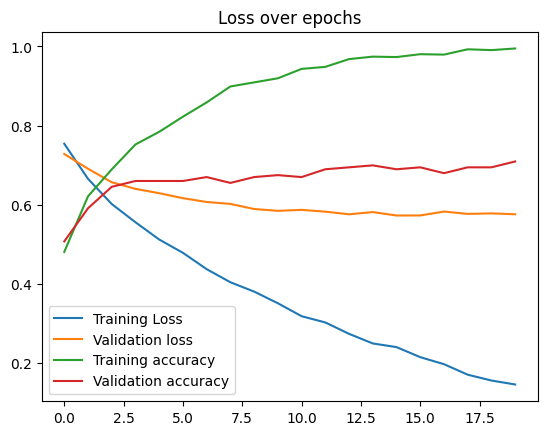

In [18]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation loss')
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.legend()
plt.title('Loss over epochs')
plt.show()

# Select the saved model for inference

In [8]:
# Load the saved model state dictionary from the .pth file
checkpoint_path = 'models\\model_epoch_20.pth'  # Adjust the path as per your saved model file
checkpoint = torch.load(checkpoint_path)

# Load the state dictionary into the model
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [9]:
model.eval() # Set the model to evaluation mode (turns off dropout and batch normalization)

# Initialize variables for accuracy calculation
correct = 0
total = 0

# Disable gradient computation
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        # Move images and labels to the device (assuming you're using GPU)
        images, labels = images.cuda(), labels.cuda()
        
        # Forward pass
        outputs = model(images)
        
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Total number of labels
        total += labels.size(0)
        
        # SKLEARN -> precision and accuracy classification report
        
        # Total correct predictions
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print('Accuracy on the test set: {:.2f}%'.format(accuracy))

100%|██████████| 4/4 [00:02<00:00,  1.99it/s]


Accuracy on the test set: 73.87%


# Inference

In [10]:
# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

In [11]:
# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

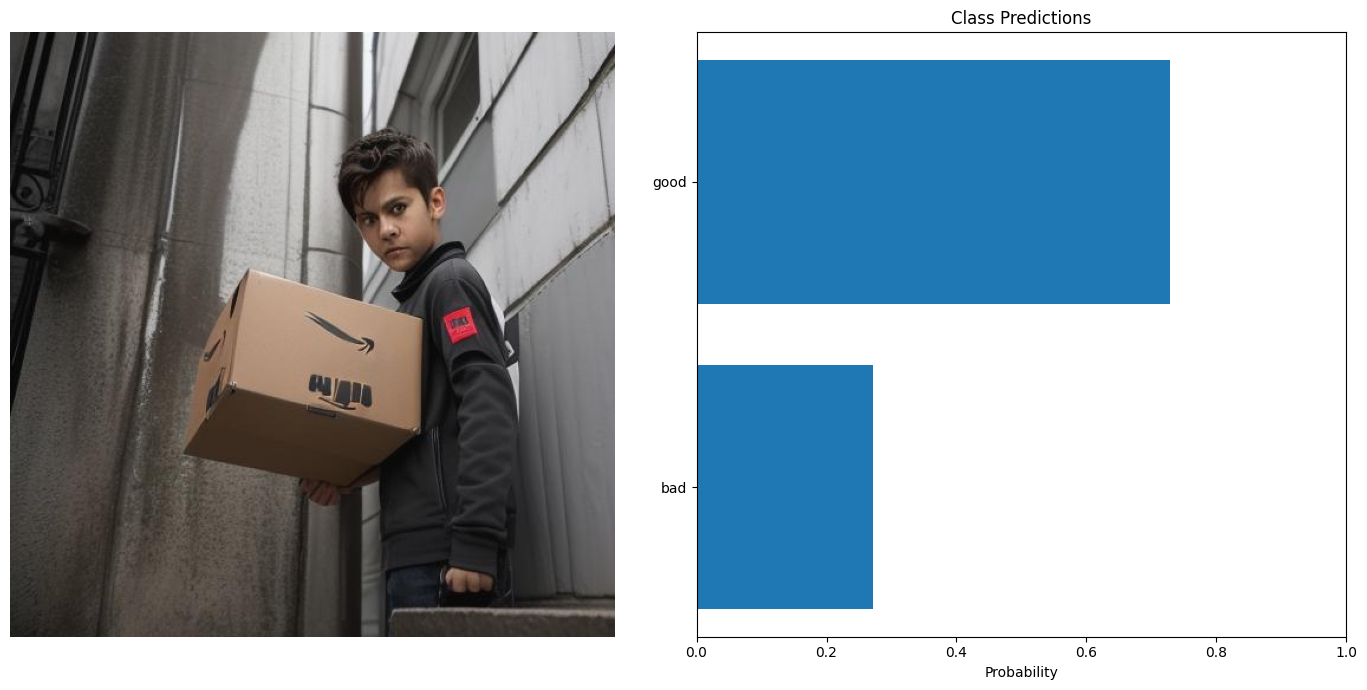

[0.2712616  0.72873837]


In [12]:
# Example usage
test_image = "sort_images\\60.jpg"
original_image, image_tensor = preprocess_image(test_image, transform_operation) # determined earlier in the code
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = train_dataset.classes 
visualize_predictions(original_image, probabilities, class_names)
print(probabilities)

In [13]:
# Run inference write to directory
import os

directory = 'sort_images/'
files = os.listdir(directory)
# sorted_files = sorted(files, key=lambda x: (int(x.split('_')[0]), int(x.split('_')[1].split('.')[0])))
sorted_files = sorted(files, key=lambda x: (int(x.split('.')[0])))
print(sorted_files, '\n')
print(len(sorted_files))

['0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg', '51.jpg', '52.jpg', '53.jpg', '54.jpg', '55.jpg', '56.jpg', '57.jpg', '58.jpg', '59.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '64.jpg', '65.jpg', '66.jpg', '67.jpg', '68.jpg', '69.jpg', '70.jpg', '71.jpg', '72.jpg', '73.jpg', '74.jpg', '75.jpg', '76.jpg', '77.jpg', '78.jpg', '79.jpg', '80.jpg', '81.jpg', '82.jpg', '83.jpg', '84.jpg', '85.jpg', '86.jpg', '87.jpg', '88.jpg', '89.jpg', '90.jpg', '91.jpg', '92.jpg', '93.jpg', '94.jpg', '95.jpg', '96.jpg', '97.jpg', '98.jpg', '99.jpg', '100.jpg'

In [15]:
for file in tqdm(sorted_files):
    original_image, image_tensor = preprocess_image("sort_images/" + file, transform_operation) # determined earlier in the code
    probabilities = predict(model, image_tensor, device)
    print(probabilities)
    
    if probabilities[1] > probabilities[0]:
        print(f"Image {file} is good, writing to good directory")
        original_image.save(f'results/good/{file}')
    else:
        print(f"Image {file} is bad, writing to bad directory")
        # original_image.save(f'results/bad/{file}')

  1%|          | 15/1600 [00:00<00:21, 74.52it/s]

[0.3456373  0.65436274]
Image 0.jpg is good, writing to good directory
[0.5170751 0.4829249]
Image 1.jpg is bad, writing to bad directory
[0.8817866  0.11821339]
Image 2.jpg is bad, writing to bad directory
[0.07951959 0.92048043]
Image 3.jpg is good, writing to good directory
[0.26279417 0.73720586]
Image 4.jpg is good, writing to good directory
[0.44662213 0.5533779 ]
Image 5.jpg is good, writing to good directory
[0.16819204 0.8318079 ]
Image 6.jpg is good, writing to good directory
[0.4229501 0.5770499]
Image 7.jpg is good, writing to good directory
[0.05363504 0.94636494]
Image 8.jpg is good, writing to good directory
[0.4513283 0.5486717]
Image 9.jpg is good, writing to good directory
[0.8073412  0.19265875]
Image 10.jpg is bad, writing to bad directory
[0.8911221 0.1088779]
Image 11.jpg is bad, writing to bad directory
[0.69063234 0.3093677 ]
Image 12.jpg is bad, writing to bad directory
[0.98475164 0.01524837]
Image 13.jpg is bad, writing to bad directory
[0.507405 0.492595]
Im

  2%|▏         | 31/1600 [00:00<00:20, 75.37it/s]

[0.13268656 0.86731344]
Image 15.jpg is good, writing to good directory
[0.19280957 0.8071904 ]
Image 16.jpg is good, writing to good directory
[0.13154063 0.86845934]
Image 17.jpg is good, writing to good directory
[0.2280897  0.77191025]
Image 18.jpg is good, writing to good directory
[0.4977479 0.5022521]
Image 19.jpg is good, writing to good directory
[0.10569882 0.89430124]
Image 20.jpg is good, writing to good directory
[0.59841484 0.40158513]
Image 21.jpg is bad, writing to bad directory
[0.5564073  0.44359273]
Image 22.jpg is bad, writing to bad directory
[0.9803155  0.01968445]
Image 23.jpg is bad, writing to bad directory
[0.38873455 0.6112655 ]
Image 24.jpg is good, writing to good directory
[0.58133626 0.41866368]
Image 25.jpg is bad, writing to bad directory
[0.49254832 0.5074517 ]
Image 26.jpg is good, writing to good directory
[0.07513829 0.9248617 ]
Image 27.jpg is good, writing to good directory
[0.12245981 0.87754023]
Image 28.jpg is good, writing to good directory
[0

  2%|▏         | 39/1600 [00:00<00:21, 73.39it/s]

[0.7164123  0.28358772]
Image 31.jpg is bad, writing to bad directory
[0.5375033 0.4624967]
Image 32.jpg is bad, writing to bad directory
[0.9136403  0.08635962]
Image 33.jpg is bad, writing to bad directory
[0.63784665 0.36215338]
Image 34.jpg is bad, writing to bad directory
[0.05171264 0.94828737]
Image 35.jpg is good, writing to good directory
[0.75604224 0.24395773]
Image 36.jpg is bad, writing to bad directory
[0.05387354 0.94612646]
Image 37.jpg is good, writing to good directory
[0.3945086 0.6054914]
Image 38.jpg is good, writing to good directory
[0.2145505 0.7854495]
Image 39.jpg is good, writing to good directory
[0.2407123  0.75928766]
Image 40.jpg is good, writing to good directory
[0.20919314 0.7908069 ]
Image 41.jpg is good, writing to good directory
[0.07625414 0.9237458 ]
Image 42.jpg is good, writing to good directory
[0.87398934 0.12601064]
Image 43.jpg is bad, writing to bad directory
[0.42085403 0.57914597]
Image 44.jpg is good, writing to good directory
[0.1078934

  3%|▎         | 55/1600 [00:00<00:20, 74.33it/s]

[0.74710655 0.25289345]
Image 46.jpg is bad, writing to bad directory
[0.06616572 0.93383425]
Image 47.jpg is good, writing to good directory
[0.719848   0.28015202]
Image 48.jpg is bad, writing to bad directory
[0.6781323  0.32186767]
Image 49.jpg is bad, writing to bad directory
[0.6397267  0.36027333]
Image 50.jpg is bad, writing to bad directory
[0.72321963 0.27678034]
Image 51.jpg is bad, writing to bad directory
[0.43257564 0.56742436]
Image 52.jpg is good, writing to good directory
[0.8956446  0.10435541]
Image 53.jpg is bad, writing to bad directory
[0.5541857  0.44581434]
Image 54.jpg is bad, writing to bad directory
[0.3444163  0.65558374]
Image 55.jpg is good, writing to good directory
[0.49752256 0.5024774 ]
Image 56.jpg is good, writing to good directory
[0.866436   0.13356404]
Image 57.jpg is bad, writing to bad directory
[0.2356558 0.7643442]
Image 58.jpg is good, writing to good directory
[0.6830975  0.31690255]
Image 59.jpg is bad, writing to bad directory
[0.2712616  

  4%|▍         | 71/1600 [00:00<00:20, 72.86it/s]

[0.3736417 0.6263583]
Image 63.jpg is good, writing to good directory
[0.50145835 0.49854165]
Image 64.jpg is bad, writing to bad directory
[0.33954275 0.6604573 ]
Image 65.jpg is good, writing to good directory
[0.4281985  0.57180154]
Image 66.jpg is good, writing to good directory
[0.3918357 0.6081643]
Image 67.jpg is good, writing to good directory
[0.00883696 0.991163  ]
Image 68.jpg is good, writing to good directory
[0.9829075  0.01709252]
Image 69.jpg is bad, writing to bad directory
[0.06719838 0.93280166]
Image 70.jpg is good, writing to good directory
[0.2740715 0.7259285]
Image 71.jpg is good, writing to good directory
[0.40058735 0.5994127 ]
Image 72.jpg is good, writing to good directory
[0.8763393  0.12366067]
Image 73.jpg is bad, writing to bad directory
[0.56039274 0.43960726]
Image 74.jpg is bad, writing to bad directory
[0.61235344 0.38764653]
Image 75.jpg is bad, writing to bad directory
[0.26499793 0.73500204]
Image 76.jpg is good, writing to good directory
[0.70361

  5%|▌         | 87/1600 [00:01<00:20, 72.49it/s]

[0.8800759  0.11992408]
Image 78.jpg is bad, writing to bad directory
[0.63280684 0.36719313]
Image 79.jpg is bad, writing to bad directory
[0.7069861  0.29301393]
Image 80.jpg is bad, writing to bad directory
[0.4894659 0.5105341]
Image 81.jpg is good, writing to good directory
[0.18323989 0.81676006]
Image 82.jpg is good, writing to good directory
[0.2407949 0.7592051]
Image 83.jpg is good, writing to good directory
[0.15696816 0.8430319 ]
Image 84.jpg is good, writing to good directory
[0.26030138 0.7396986 ]
Image 85.jpg is good, writing to good directory
[0.09306791 0.9069321 ]
Image 86.jpg is good, writing to good directory
[0.94966084 0.05033913]
Image 87.jpg is bad, writing to bad directory
[0.9324488  0.06755114]
Image 88.jpg is bad, writing to bad directory
[0.42152587 0.57847416]
Image 89.jpg is good, writing to good directory
[0.12437647 0.8756235 ]
Image 90.jpg is good, writing to good directory
[0.56562144 0.43437856]
Image 91.jpg is bad, writing to bad directory
[0.52325

  6%|▋         | 104/1600 [00:01<00:19, 75.64it/s]

[0.5500628 0.4499372]
Image 93.jpg is bad, writing to bad directory
[0.3680943  0.63190573]
Image 94.jpg is good, writing to good directory
[0.5471481  0.45285192]
Image 95.jpg is bad, writing to bad directory
[0.60633594 0.3936641 ]
Image 96.jpg is bad, writing to bad directory
[0.8764089  0.12359113]
Image 97.jpg is bad, writing to bad directory
[0.49628484 0.5037152 ]
Image 98.jpg is good, writing to good directory
[0.02672912 0.9732709 ]
Image 99.jpg is good, writing to good directory
[0.8690595  0.13094047]
Image 100.jpg is bad, writing to bad directory
[0.98150074 0.01849921]
Image 101.jpg is bad, writing to bad directory
[0.43780467 0.5621953 ]
Image 102.jpg is good, writing to good directory
[0.83892304 0.1610769 ]
Image 103.jpg is bad, writing to bad directory
[0.13871266 0.86128736]
Image 104.jpg is good, writing to good directory
[0.2988349  0.70116514]
Image 105.jpg is good, writing to good directory
[0.87202287 0.12797716]
Image 106.jpg is bad, writing to bad directory
[0.

  8%|▊         | 120/1600 [00:01<00:20, 72.11it/s]

[0.69235444 0.30764556]
Image 109.jpg is bad, writing to bad directory
[0.9528901  0.04710991]
Image 110.jpg is bad, writing to bad directory
[0.4897584  0.51024157]
Image 111.jpg is good, writing to good directory
[0.35854617 0.64145386]
Image 112.jpg is good, writing to good directory
[0.10167991 0.8983201 ]
Image 113.jpg is good, writing to good directory
[0.55640584 0.44359413]
Image 114.jpg is bad, writing to bad directory
[0.01348996 0.9865101 ]
Image 115.jpg is good, writing to good directory
[0.6055987 0.3944013]
Image 116.jpg is bad, writing to bad directory
[0.19165581 0.8083442 ]
Image 117.jpg is good, writing to good directory
[0.35285804 0.647142  ]
Image 118.jpg is good, writing to good directory
[0.06348678 0.9365132 ]
Image 119.jpg is good, writing to good directory
[0.38549215 0.6145078 ]
Image 120.jpg is good, writing to good directory
[0.22315349 0.7768465 ]
Image 121.jpg is good, writing to good directory
[0.648239   0.35176104]
Image 122.jpg is bad, writing to bad 

  8%|▊         | 136/1600 [00:01<00:20, 72.01it/s]

[0.19859493 0.8014051 ]
Image 124.jpg is good, writing to good directory
[0.38887808 0.61112195]
Image 125.jpg is good, writing to good directory
[0.17664897 0.823351  ]
Image 126.jpg is good, writing to good directory
[0.82943773 0.17056227]
Image 127.jpg is bad, writing to bad directory
[0.04963635 0.95036364]
Image 128.jpg is good, writing to good directory
[0.438496 0.561504]
Image 129.jpg is good, writing to good directory
[0.06355146 0.9364486 ]
Image 130.jpg is good, writing to good directory
[0.16822854 0.83177143]
Image 131.jpg is good, writing to good directory
[0.875789   0.12421098]
Image 132.jpg is bad, writing to bad directory
[0.08107868 0.9189213 ]
Image 133.jpg is good, writing to good directory
[0.7835292  0.21647073]
Image 134.jpg is bad, writing to bad directory
[0.2341475 0.7658525]
Image 135.jpg is good, writing to good directory
[0.67397636 0.32602364]
Image 136.jpg is bad, writing to bad directory
[0.3198467  0.68015337]
Image 137.jpg is good, writing to good di

 10%|▉         | 152/1600 [00:02<00:19, 72.63it/s]

[0.1674837  0.83251625]
Image 140.jpg is good, writing to good directory
[0.10927455 0.89072543]
Image 141.jpg is good, writing to good directory
[0.70742947 0.2925706 ]
Image 142.jpg is bad, writing to bad directory
[0.0566567  0.94334334]
Image 143.jpg is good, writing to good directory
[0.78703773 0.21296225]
Image 144.jpg is bad, writing to bad directory
[0.9329163  0.06708374]
Image 145.jpg is bad, writing to bad directory
[0.0057393  0.99426067]
Image 146.jpg is good, writing to good directory
[0.3579688  0.64203125]
Image 147.jpg is good, writing to good directory
[0.21084943 0.78915054]
Image 148.jpg is good, writing to good directory
[0.88105637 0.11894362]
Image 149.jpg is bad, writing to bad directory
[0.3867736 0.6132265]
Image 150.jpg is good, writing to good directory
[0.18948679 0.8105132 ]
Image 151.jpg is good, writing to good directory
[0.8010174  0.19898266]
Image 152.jpg is bad, writing to bad directory
[0.0295502 0.9704498]
Image 153.jpg is good, writing to good di

 10%|█         | 160/1600 [00:02<00:21, 66.18it/s]

[0.4704741  0.52952594]
Image 154.jpg is good, writing to good directory
[0.32457173 0.6754282 ]
Image 155.jpg is good, writing to good directory
[0.7496128 0.2503872]
Image 156.jpg is bad, writing to bad directory
[0.969912   0.03008794]
Image 157.jpg is bad, writing to bad directory
[0.25556716 0.74443287]
Image 158.jpg is good, writing to good directory
[0.23601006 0.7639899 ]
Image 159.jpg is good, writing to good directory
[0.5752055 0.4247945]
Image 160.jpg is bad, writing to bad directory
[0.15965515 0.84034485]
Image 161.jpg is good, writing to good directory
[0.726314 0.273686]
Image 162.jpg is bad, writing to bad directory
[0.3273865  0.67261356]
Image 163.jpg is good, writing to good directory
[0.41417164 0.5858284 ]
Image 164.jpg is good, writing to good directory
[0.04105109 0.9589489 ]
Image 165.jpg is good, writing to good directory
[0.7423067  0.25769332]
Image 166.jpg is bad, writing to bad directory
[0.06585696 0.934143  ]
Image 167.jpg is good, writing to good direct

 11%|█         | 176/1600 [00:02<00:20, 68.16it/s]

[0.2957488 0.7042512]
Image 168.jpg is good, writing to good directory
[0.06281321 0.9371868 ]
Image 169.jpg is good, writing to good directory
[0.87035763 0.1296423 ]
Image 170.jpg is bad, writing to bad directory
[0.0986408  0.90135914]
Image 171.jpg is good, writing to good directory
[0.63393974 0.3660603 ]
Image 172.jpg is bad, writing to bad directory
[0.0377269 0.9622731]
Image 173.jpg is good, writing to good directory
[0.3662589 0.6337411]
Image 174.jpg is good, writing to good directory
[0.17226577 0.82773423]
Image 175.jpg is good, writing to good directory
[0.5708096  0.42919037]
Image 176.jpg is bad, writing to bad directory
[0.14762023 0.8523798 ]
Image 177.jpg is good, writing to good directory
[0.5546575  0.44534248]
Image 178.jpg is bad, writing to bad directory
[0.49881318 0.50118685]
Image 179.jpg is good, writing to good directory
[0.725019   0.27498105]
Image 180.jpg is bad, writing to bad directory
[0.2192188  0.78078115]
Image 181.jpg is good, writing to good dire

 12%|█▏        | 191/1600 [00:02<00:20, 69.48it/s]

[0.5235864  0.47641364]
Image 182.jpg is bad, writing to bad directory
[0.2937301 0.7062699]
Image 183.jpg is good, writing to good directory
[0.33249858 0.66750145]
Image 184.jpg is good, writing to good directory
[0.29009983 0.7099002 ]
Image 185.jpg is good, writing to good directory
[0.11260024 0.8873998 ]
Image 186.jpg is good, writing to good directory
[0.14828138 0.8517186 ]
Image 187.jpg is good, writing to good directory
[0.03156586 0.9684342 ]
Image 188.jpg is good, writing to good directory
[0.9103534 0.0896466]
Image 189.jpg is bad, writing to bad directory
[0.05865664 0.94134337]
Image 190.jpg is good, writing to good directory
[0.9379045  0.06209551]
Image 191.jpg is bad, writing to bad directory
[0.61034495 0.389655  ]
Image 192.jpg is bad, writing to bad directory
[0.5049797  0.49502024]
Image 193.jpg is bad, writing to bad directory
[0.8193147  0.18068527]
Image 194.jpg is bad, writing to bad directory
[0.8457279  0.15427205]
Image 195.jpg is bad, writing to bad direct

 13%|█▎        | 207/1600 [00:02<00:19, 71.03it/s]

[0.69618 0.30382]
Image 197.jpg is bad, writing to bad directory
[0.25994033 0.7400597 ]
Image 198.jpg is good, writing to good directory
[0.6598474  0.34015262]
Image 199.jpg is bad, writing to bad directory
[0.34824517 0.65175486]
Image 200.jpg is good, writing to good directory
[0.3498269 0.6501731]
Image 201.jpg is good, writing to good directory
[0.3436771  0.65632296]
Image 202.jpg is good, writing to good directory
[0.09861998 0.90138   ]
Image 203.jpg is good, writing to good directory
[0.26261568 0.7373843 ]
Image 204.jpg is good, writing to good directory
[0.01481123 0.98518884]
Image 205.jpg is good, writing to good directory
[0.31471422 0.6852858 ]
Image 206.jpg is good, writing to good directory
[0.31615782 0.6838421 ]
Image 207.jpg is good, writing to good directory
[0.21336298 0.786637  ]
Image 208.jpg is good, writing to good directory
[0.44876194 0.55123806]
Image 209.jpg is good, writing to good directory
[0.736018   0.26398203]
Image 210.jpg is bad, writing to bad di

 14%|█▍        | 223/1600 [00:03<00:19, 71.52it/s]

[0.8540378 0.1459622]
Image 212.jpg is bad, writing to bad directory
[0.8783058  0.12169418]
Image 213.jpg is bad, writing to bad directory
[0.31844378 0.6815562 ]
Image 214.jpg is good, writing to good directory
[0.2565376  0.74346244]
Image 215.jpg is good, writing to good directory
[0.7994258 0.2005742]
Image 216.jpg is bad, writing to bad directory
[0.5262695 0.4737305]
Image 217.jpg is bad, writing to bad directory
[0.38581017 0.61418986]
Image 218.jpg is good, writing to good directory
[0.04971522 0.95028484]
Image 219.jpg is good, writing to good directory
[0.7739505  0.22604953]
Image 220.jpg is bad, writing to bad directory
[0.09625193 0.9037481 ]
Image 221.jpg is good, writing to good directory
[0.5929457  0.40705428]
Image 222.jpg is bad, writing to bad directory
[0.73962915 0.26037088]
Image 223.jpg is bad, writing to bad directory
[0.6047683  0.39523175]
Image 224.jpg is bad, writing to bad directory
[0.5002349 0.4997651]
Image 225.jpg is bad, writing to bad directory
[0.2

 15%|█▍        | 239/1600 [00:03<00:18, 73.35it/s]

[0.9607821  0.03921793]
Image 227.jpg is bad, writing to bad directory
[0.8452043  0.15479565]
Image 228.jpg is bad, writing to bad directory
[0.28922397 0.71077603]
Image 229.jpg is good, writing to good directory
[0.20801929 0.79198074]
Image 230.jpg is good, writing to good directory
[0.73811275 0.26188722]
Image 231.jpg is bad, writing to bad directory
[0.2268573  0.77314276]
Image 232.jpg is good, writing to good directory
[0.49400395 0.50599605]
Image 233.jpg is good, writing to good directory
[0.5320388 0.4679612]
Image 234.jpg is bad, writing to bad directory
[0.60530794 0.39469206]
Image 235.jpg is bad, writing to bad directory
[0.17617044 0.82382953]
Image 236.jpg is good, writing to good directory
[0.9931338  0.00686615]
Image 237.jpg is bad, writing to bad directory
[0.12846206 0.871538  ]
Image 238.jpg is good, writing to good directory
[0.06913122 0.9308688 ]
Image 239.jpg is good, writing to good directory
[0.2505823 0.7494177]
Image 240.jpg is good, writing to good dire

 16%|█▌        | 255/1600 [00:03<00:18, 71.75it/s]

[0.22581038 0.77418965]
Image 242.jpg is good, writing to good directory
[0.8360991 0.1639009]
Image 243.jpg is bad, writing to bad directory
[0.18929455 0.8107055 ]
Image 244.jpg is good, writing to good directory
[0.3318749 0.6681251]
Image 245.jpg is good, writing to good directory
[0.38605252 0.61394745]
Image 246.jpg is good, writing to good directory
[0.51743644 0.48256353]
Image 247.jpg is bad, writing to bad directory
[0.01526739 0.98473257]
Image 248.jpg is good, writing to good directory
[0.15947694 0.840523  ]
Image 249.jpg is good, writing to good directory
[0.36599937 0.6340006 ]
Image 250.jpg is good, writing to good directory
[0.70089006 0.29910997]
Image 251.jpg is bad, writing to bad directory
[0.59762114 0.40237892]
Image 252.jpg is bad, writing to bad directory
[0.3603423 0.6396577]
Image 253.jpg is good, writing to good directory
[0.64403695 0.35596302]
Image 254.jpg is bad, writing to bad directory
[0.9806066  0.01939339]
Image 255.jpg is bad, writing to bad direct

 17%|█▋        | 271/1600 [00:03<00:18, 71.95it/s]

[0.07171161 0.9282884 ]
Image 257.jpg is good, writing to good directory
[0.06082283 0.93917716]
Image 258.jpg is good, writing to good directory
[0.38429838 0.6157016 ]
Image 259.jpg is good, writing to good directory
[0.70790553 0.29209447]
Image 260.jpg is bad, writing to bad directory
[0.34931403 0.65068597]
Image 261.jpg is good, writing to good directory
[0.09882254 0.90117747]
Image 262.jpg is good, writing to good directory
[0.9929609  0.00703907]
Image 263.jpg is bad, writing to bad directory
[0.53910106 0.46089894]
Image 264.jpg is bad, writing to bad directory
[0.781139   0.21886103]
Image 265.jpg is bad, writing to bad directory
[0.08431552 0.91568446]
Image 266.jpg is good, writing to good directory
[0.1422159 0.8577841]
Image 267.jpg is good, writing to good directory
[0.53313285 0.4668671 ]
Image 268.jpg is bad, writing to bad directory
[0.9701536  0.02984635]
Image 269.jpg is bad, writing to bad directory
[0.1899555 0.8100445]
Image 270.jpg is good, writing to good dire

 17%|█▋        | 279/1600 [00:03<00:18, 71.60it/s]

[0.36920366 0.6307963 ]
Image 271.jpg is good, writing to good directory
[0.55475485 0.44524518]
Image 272.jpg is bad, writing to bad directory
[0.988932   0.01106794]
Image 273.jpg is bad, writing to bad directory
[0.46019888 0.5398011 ]
Image 274.jpg is good, writing to good directory
[0.47771394 0.522286  ]
Image 275.jpg is good, writing to good directory
[0.5569468  0.44305316]
Image 276.jpg is bad, writing to bad directory
[0.01565861 0.9843413 ]
Image 277.jpg is good, writing to good directory
[0.49461982 0.5053802 ]
Image 278.jpg is good, writing to good directory
[0.97362703 0.02637297]
Image 279.jpg is bad, writing to bad directory
[0.47317484 0.5268252 ]
Image 280.jpg is good, writing to good directory
[0.11724198 0.8827581 ]
Image 281.jpg is good, writing to good directory
[0.58302194 0.41697803]
Image 282.jpg is bad, writing to bad directory
[0.5450977 0.4549023]
Image 283.jpg is bad, writing to bad directory


 18%|█▊        | 295/1600 [00:04<00:17, 72.78it/s]

[0.37734154 0.6226585 ]
Image 284.jpg is good, writing to good directory
[0.8159635 0.1840365]
Image 285.jpg is bad, writing to bad directory
[0.56357807 0.4364219 ]
Image 286.jpg is bad, writing to bad directory
[0.8625463  0.13745366]
Image 287.jpg is bad, writing to bad directory
[0.2969821  0.70301783]
Image 288.jpg is good, writing to good directory
[0.334407   0.66559297]
Image 289.jpg is good, writing to good directory
[0.3985882  0.60141176]
Image 290.jpg is good, writing to good directory
[0.82420826 0.1757917 ]
Image 291.jpg is bad, writing to bad directory
[0.59908855 0.40091145]
Image 292.jpg is bad, writing to bad directory
[0.82631576 0.17368421]
Image 293.jpg is bad, writing to bad directory
[0.76662046 0.23337953]
Image 294.jpg is bad, writing to bad directory
[0.0647615  0.93523854]
Image 295.jpg is good, writing to good directory
[0.77610123 0.2238988 ]
Image 296.jpg is bad, writing to bad directory
[0.5202776  0.47972232]
Image 297.jpg is bad, writing to bad director

 19%|█▉        | 311/1600 [00:04<00:17, 73.62it/s]

[0.5786074  0.42139265]
Image 299.jpg is bad, writing to bad directory
[0.20760204 0.792398  ]
Image 300.jpg is good, writing to good directory
[0.19205447 0.8079455 ]
Image 301.jpg is good, writing to good directory
[0.5187991  0.48120093]
Image 302.jpg is bad, writing to bad directory
[0.29317448 0.7068255 ]
Image 303.jpg is good, writing to good directory
[0.07835571 0.9216443 ]
Image 304.jpg is good, writing to good directory
[0.53386205 0.4661379 ]
Image 305.jpg is bad, writing to bad directory
[0.6298281 0.3701719]
Image 306.jpg is bad, writing to bad directory
[0.99217564 0.0078244 ]
Image 307.jpg is bad, writing to bad directory
[0.341135   0.65886503]
Image 308.jpg is good, writing to good directory
[0.71013343 0.28986657]
Image 309.jpg is bad, writing to bad directory
[0.37260187 0.62739813]
Image 310.jpg is good, writing to good directory
[0.23534371 0.76465625]
Image 311.jpg is good, writing to good directory
[0.41144702 0.588553  ]
Image 312.jpg is good, writing to good di

 20%|██        | 327/1600 [00:04<00:17, 71.78it/s]

[0.81674254 0.18325752]
Image 315.jpg is bad, writing to bad directory
[0.30811548 0.6918845 ]
Image 316.jpg is good, writing to good directory
[0.27406955 0.7259304 ]
Image 317.jpg is good, writing to good directory
[0.4075606 0.5924394]
Image 318.jpg is good, writing to good directory
[0.89604056 0.10395945]
Image 319.jpg is bad, writing to bad directory
[0.37081257 0.62918746]
Image 320.jpg is good, writing to good directory
[0.23286384 0.76713616]
Image 321.jpg is good, writing to good directory
[0.11039078 0.8896093 ]
Image 322.jpg is good, writing to good directory
[0.38657722 0.61342275]
Image 323.jpg is good, writing to good directory
[0.5778724  0.42212766]
Image 324.jpg is bad, writing to bad directory
[0.61471    0.38529006]
Image 325.jpg is bad, writing to bad directory
[0.34353456 0.6564654 ]
Image 326.jpg is good, writing to good directory
[0.72817594 0.27182403]
Image 327.jpg is bad, writing to bad directory
[0.523365   0.47663498]
Image 328.jpg is bad, writing to bad di

 21%|██        | 336/1600 [00:04<00:17, 74.16it/s]

[0.71406716 0.2859329 ]
Image 330.jpg is bad, writing to bad directory
[0.5381029 0.4618971]
Image 331.jpg is bad, writing to bad directory
[0.14895271 0.8510473 ]
Image 332.jpg is good, writing to good directory
[0.61455286 0.38544714]
Image 333.jpg is bad, writing to bad directory
[0.8193493  0.18065068]
Image 334.jpg is bad, writing to bad directory
[0.42317542 0.57682455]
Image 335.jpg is good, writing to good directory
[0.45545384 0.5445461 ]
Image 336.jpg is good, writing to good directory
[0.16407335 0.8359266 ]
Image 337.jpg is good, writing to good directory
[0.7893314  0.21066864]
Image 338.jpg is bad, writing to bad directory
[0.16799127 0.8320087 ]
Image 339.jpg is good, writing to good directory
[0.20762978 0.7923702 ]
Image 340.jpg is good, writing to good directory
[0.27780792 0.7221921 ]
Image 341.jpg is good, writing to good directory
[0.5162708  0.48372918]
Image 342.jpg is bad, writing to bad directory
[0.42337456 0.57662547]
Image 343.jpg is good, writing to good di

 22%|██▏       | 352/1600 [00:04<00:17, 72.25it/s]

[0.2409923  0.75900775]
Image 344.jpg is good, writing to good directory
[0.07244201 0.92755795]
Image 345.jpg is good, writing to good directory
[0.18299724 0.8170027 ]
Image 346.jpg is good, writing to good directory
[0.6303037  0.36969638]
Image 347.jpg is bad, writing to bad directory
[0.18996465 0.81003535]
Image 348.jpg is good, writing to good directory
[0.32784262 0.6721574 ]
Image 349.jpg is good, writing to good directory
[0.00626464 0.9937354 ]
Image 350.jpg is good, writing to good directory
[0.3476625  0.65233755]
Image 351.jpg is good, writing to good directory
[0.03103923 0.96896076]
Image 352.jpg is good, writing to good directory
[0.06387749 0.93612254]
Image 353.jpg is good, writing to good directory
[0.4172915 0.5827085]
Image 354.jpg is good, writing to good directory
[0.53384846 0.46615148]
Image 355.jpg is bad, writing to bad directory
[0.5856524 0.4143476]
Image 356.jpg is bad, writing to bad directory
[0.4057954 0.5942046]
Image 357.jpg is good, writing to good 

 23%|██▎       | 368/1600 [00:05<00:18, 65.10it/s]

[0.6049555  0.39504448]
Image 358.jpg is bad, writing to bad directory
[0.92839855 0.07160144]
Image 359.jpg is bad, writing to bad directory
[0.12305401 0.87694603]
Image 360.jpg is good, writing to good directory
[0.328471 0.671529]
Image 361.jpg is good, writing to good directory
[0.80925953 0.19074044]
Image 362.jpg is bad, writing to bad directory
[0.4613597  0.53864026]
Image 363.jpg is good, writing to good directory
[0.27009788 0.72990215]
Image 364.jpg is good, writing to good directory
[0.43123153 0.56876844]
Image 365.jpg is good, writing to good directory
[0.6620042 0.3379958]
Image 366.jpg is bad, writing to bad directory
[0.17309478 0.82690525]
Image 367.jpg is good, writing to good directory
[0.74786496 0.25213504]
Image 368.jpg is bad, writing to bad directory
[0.05905864 0.9409414 ]
Image 369.jpg is good, writing to good directory


 24%|██▍       | 384/1600 [00:05<00:17, 69.95it/s]

[0.32082367 0.67917633]
Image 370.jpg is good, writing to good directory
[0.25171137 0.7482887 ]
Image 371.jpg is good, writing to good directory
[0.6869352  0.31306475]
Image 372.jpg is bad, writing to bad directory
[0.7986354  0.20136458]
Image 373.jpg is bad, writing to bad directory
[0.38040802 0.61959195]
Image 374.jpg is good, writing to good directory
[0.03857115 0.9614288 ]
Image 375.jpg is good, writing to good directory
[0.8105899  0.18941005]
Image 376.jpg is bad, writing to bad directory
[0.88878906 0.11121094]
Image 377.jpg is bad, writing to bad directory
[0.8441718 0.1558282]
Image 378.jpg is bad, writing to bad directory
[0.05372963 0.94627035]
Image 379.jpg is good, writing to good directory
[0.77262384 0.2273762 ]
Image 380.jpg is bad, writing to bad directory
[0.7137168  0.28628317]
Image 381.jpg is bad, writing to bad directory
[0.26059255 0.7394075 ]
Image 382.jpg is good, writing to good directory
[0.07375091 0.9262491 ]
Image 383.jpg is good, writing to good dire

 24%|██▍       | 392/1600 [00:05<00:17, 69.47it/s]

[0.07166039 0.92833966]
Image 386.jpg is good, writing to good directory
[0.30028358 0.69971645]
Image 387.jpg is good, writing to good directory
[0.7279791  0.27202088]
Image 388.jpg is bad, writing to bad directory
[0.03240356 0.9675964 ]
Image 389.jpg is good, writing to good directory
[0.32956675 0.6704332 ]
Image 390.jpg is good, writing to good directory
[0.81940764 0.18059233]
Image 391.jpg is bad, writing to bad directory
[0.69242424 0.30757576]
Image 392.jpg is bad, writing to bad directory
[0.44658628 0.55341375]
Image 393.jpg is good, writing to good directory
[0.09208377 0.9079162 ]
Image 394.jpg is good, writing to good directory
[0.91686773 0.0831323 ]
Image 395.jpg is bad, writing to bad directory
[0.80947787 0.19052216]
Image 396.jpg is bad, writing to bad directory
[0.88217866 0.11782136]
Image 397.jpg is bad, writing to bad directory
[0.09068988 0.90931016]
Image 398.jpg is good, writing to good directory
[0.78958946 0.2104105 ]
Image 399.jpg is bad, writing to bad di

 26%|██▌       | 408/1600 [00:05<00:16, 71.45it/s]

[0.3728538  0.62714624]
Image 400.jpg is good, writing to good directory
[0.96103257 0.03896745]
Image 401.jpg is bad, writing to bad directory
[0.8625076 0.1374924]
Image 402.jpg is bad, writing to bad directory
[0.5157852  0.48421475]
Image 403.jpg is bad, writing to bad directory
[0.2128267 0.7871733]
Image 404.jpg is good, writing to good directory
[0.69396925 0.30603078]
Image 405.jpg is bad, writing to bad directory
[0.8476261  0.15237388]
Image 406.jpg is bad, writing to bad directory
[0.00654271 0.99345726]
Image 407.jpg is good, writing to good directory
[0.6489945  0.35100546]
Image 408.jpg is bad, writing to bad directory
[0.9475122 0.0524878]
Image 409.jpg is bad, writing to bad directory
[0.11165474 0.8883453 ]
Image 410.jpg is good, writing to good directory
[0.47141293 0.52858704]
Image 411.jpg is good, writing to good directory
[0.72526675 0.27473328]
Image 412.jpg is bad, writing to bad directory
[0.8942372  0.10576275]
Image 413.jpg is bad, writing to bad directory
[0

 26%|██▋       | 424/1600 [00:05<00:16, 71.73it/s]

[0.2715463  0.72845376]
Image 415.jpg is good, writing to good directory
[0.02990604 0.97009397]
Image 416.jpg is good, writing to good directory
[0.87297666 0.12702337]
Image 417.jpg is bad, writing to bad directory
[0.39428315 0.6057169 ]
Image 418.jpg is good, writing to good directory
[0.61003673 0.38996324]
Image 419.jpg is bad, writing to bad directory
[0.13664521 0.8633548 ]
Image 420.jpg is good, writing to good directory
[0.47133827 0.52866167]
Image 421.jpg is good, writing to good directory
[0.4503593 0.5496407]
Image 422.jpg is good, writing to good directory
[0.43360433 0.56639564]
Image 423.jpg is good, writing to good directory
[0.13775285 0.86224717]
Image 424.jpg is good, writing to good directory
[0.16493528 0.83506477]
Image 425.jpg is good, writing to good directory
[0.00804256 0.9919574 ]
Image 426.jpg is good, writing to good directory
[0.94928044 0.05071954]
Image 427.jpg is bad, writing to bad directory
[0.21093561 0.78906435]
Image 428.jpg is good, writing to g

 28%|██▊       | 440/1600 [00:06<00:15, 73.17it/s]

[0.4998123 0.5001877]
Image 430.jpg is good, writing to good directory
[0.00940644 0.9905936 ]
Image 431.jpg is good, writing to good directory
[0.5520341  0.44796598]
Image 432.jpg is bad, writing to bad directory
[0.05738792 0.94261205]
Image 433.jpg is good, writing to good directory
[0.9031157  0.09688427]
Image 434.jpg is bad, writing to bad directory
[0.31101763 0.68898237]
Image 435.jpg is good, writing to good directory
[0.5345788  0.46542123]
Image 436.jpg is bad, writing to bad directory
[0.46102598 0.53897405]
Image 437.jpg is good, writing to good directory
[0.8895338  0.11046616]
Image 438.jpg is bad, writing to bad directory
[0.08895743 0.91104263]
Image 439.jpg is good, writing to good directory
[0.20978919 0.79021084]
Image 440.jpg is good, writing to good directory
[0.7357676 0.2642324]
Image 441.jpg is bad, writing to bad directory
[0.08577798 0.91422206]
Image 442.jpg is good, writing to good directory
[0.46212187 0.53787816]
Image 443.jpg is good, writing to good di

 28%|██▊       | 448/1600 [00:06<00:17, 64.08it/s]

[0.42503616 0.57496387]
Image 444.jpg is good, writing to good directory
[0.35027242 0.6497276 ]
Image 445.jpg is good, writing to good directory
[0.31552288 0.68447715]
Image 446.jpg is good, writing to good directory
[0.16565034 0.83434963]
Image 447.jpg is good, writing to good directory
[0.58773345 0.41226658]
Image 448.jpg is bad, writing to bad directory
[0.60885835 0.39114165]
Image 449.jpg is bad, writing to bad directory
[0.8659327  0.13406733]
Image 450.jpg is bad, writing to bad directory
[0.04070494 0.9592951 ]
Image 451.jpg is good, writing to good directory
[0.09198685 0.90801316]
Image 452.jpg is good, writing to good directory
[0.01074141 0.9892586 ]
Image 453.jpg is good, writing to good directory
[0.05925262 0.94074744]
Image 454.jpg is good, writing to good directory


 29%|██▉       | 462/1600 [00:06<00:17, 63.62it/s]

[0.53425926 0.4657407 ]
Image 455.jpg is bad, writing to bad directory
[0.548289   0.45171103]
Image 456.jpg is bad, writing to bad directory
[0.6268366  0.37316346]
Image 457.jpg is bad, writing to bad directory
[0.8218586 0.1781414]
Image 458.jpg is bad, writing to bad directory
[0.30596405 0.69403595]
Image 459.jpg is good, writing to good directory
[0.6351988 0.3648012]
Image 460.jpg is bad, writing to bad directory
[0.07229621 0.92770374]
Image 461.jpg is good, writing to good directory
[0.83164907 0.16835093]
Image 462.jpg is bad, writing to bad directory
[0.17271176 0.8272882 ]
Image 463.jpg is good, writing to good directory
[0.39368454 0.6063155 ]
Image 464.jpg is good, writing to good directory
[0.43089923 0.5691008 ]
Image 465.jpg is good, writing to good directory
[0.0931687 0.9068313]
Image 466.jpg is good, writing to good directory
[0.3122628  0.68773717]
Image 467.jpg is good, writing to good directory
[0.5894675  0.41053247]
Image 468.jpg is bad, writing to bad director

 30%|██▉       | 477/1600 [00:06<00:16, 66.69it/s]

[0.21256052 0.7874395 ]
Image 469.jpg is good, writing to good directory
[0.6691269  0.33087307]
Image 470.jpg is bad, writing to bad directory
[0.36400124 0.6359988 ]
Image 471.jpg is good, writing to good directory
[0.27956814 0.72043186]
Image 472.jpg is good, writing to good directory
[0.08517984 0.91482013]
Image 473.jpg is good, writing to good directory
[0.36998248 0.6300175 ]
Image 474.jpg is good, writing to good directory
[0.1524325 0.8475675]
Image 475.jpg is good, writing to good directory
[0.33050472 0.6694953 ]
Image 476.jpg is good, writing to good directory
[0.1513819  0.84861815]
Image 477.jpg is good, writing to good directory
[0.48151073 0.5184893 ]
Image 478.jpg is good, writing to good directory
[0.19648878 0.8035112 ]
Image 479.jpg is good, writing to good directory
[0.16161333 0.8383867 ]
Image 480.jpg is good, writing to good directory
[0.9505131  0.04948694]
Image 481.jpg is bad, writing to bad directory
[0.21663721 0.7833628 ]
Image 482.jpg is good, writing to

 31%|███       | 491/1600 [00:06<00:16, 66.22it/s]

[0.20307082 0.7969292 ]
Image 484.jpg is good, writing to good directory
[0.04987593 0.950124  ]
Image 485.jpg is good, writing to good directory
[0.25195277 0.7480472 ]
Image 486.jpg is good, writing to good directory
[0.42121038 0.57878965]
Image 487.jpg is good, writing to good directory
[0.01428187 0.98571813]
Image 488.jpg is good, writing to good directory
[0.10542838 0.8945716 ]
Image 489.jpg is good, writing to good directory
[0.39271104 0.6072889 ]
Image 490.jpg is good, writing to good directory
[0.10406552 0.8959345 ]
Image 491.jpg is good, writing to good directory
[0.12665579 0.8733442 ]
Image 492.jpg is good, writing to good directory
[0.21692497 0.78307503]
Image 493.jpg is good, writing to good directory
[0.25012556 0.7498744 ]
Image 494.jpg is good, writing to good directory
[0.08564578 0.91435426]
Image 495.jpg is good, writing to good directory
[0.624805   0.37519506]
Image 496.jpg is bad, writing to bad directory


 32%|███▏      | 505/1600 [00:07<00:18, 58.12it/s]

[0.5817918  0.41820824]
Image 497.jpg is bad, writing to bad directory
[0.2268188 0.7731812]
Image 498.jpg is good, writing to good directory
[0.7455343  0.25446573]
Image 499.jpg is bad, writing to bad directory
[0.16445746 0.8355425 ]
Image 500.jpg is good, writing to good directory
[0.32677698 0.673223  ]
Image 501.jpg is good, writing to good directory
[0.09318727 0.9068127 ]
Image 502.jpg is good, writing to good directory
[0.5565491  0.44345093]
Image 503.jpg is bad, writing to bad directory
[0.29361507 0.70638496]
Image 504.jpg is good, writing to good directory
[0.8769952  0.12300476]
Image 505.jpg is bad, writing to bad directory
[0.4686179  0.53138214]
Image 506.jpg is good, writing to good directory


 32%|███▏      | 518/1600 [00:07<00:17, 60.99it/s]

[0.43283588 0.5671641 ]
Image 507.jpg is good, writing to good directory
[0.8754676  0.12453237]
Image 508.jpg is bad, writing to bad directory
[0.9118898  0.08811028]
Image 509.jpg is bad, writing to bad directory
[0.11925711 0.88074297]
Image 510.jpg is good, writing to good directory
[0.3715482  0.62845176]
Image 511.jpg is good, writing to good directory
[0.51173776 0.4882622 ]
Image 512.jpg is bad, writing to bad directory
[0.15129839 0.84870166]
Image 513.jpg is good, writing to good directory
[0.21209055 0.78790945]
Image 514.jpg is good, writing to good directory
[0.5625951  0.43740487]
Image 515.jpg is bad, writing to bad directory
[0.05982797 0.9401721 ]
Image 516.jpg is good, writing to good directory
[0.24770378 0.75229627]
Image 517.jpg is good, writing to good directory
[0.24014986 0.75985014]
Image 518.jpg is good, writing to good directory
[0.11651988 0.8834801 ]
Image 519.jpg is good, writing to good directory
[0.71986234 0.2801376 ]
Image 520.jpg is bad, writing to ba

 33%|███▎      | 532/1600 [00:07<00:17, 62.63it/s]

[0.37026864 0.6297313 ]
Image 521.jpg is good, writing to good directory
[0.4332814  0.56671864]
Image 522.jpg is good, writing to good directory
[0.6382728  0.36172712]
Image 523.jpg is bad, writing to bad directory
[0.2781212 0.7218788]
Image 524.jpg is good, writing to good directory
[0.8596481 0.1403519]
Image 525.jpg is bad, writing to bad directory
[0.24641167 0.7535884 ]
Image 526.jpg is good, writing to good directory
[0.10564711 0.8943529 ]
Image 527.jpg is good, writing to good directory
[0.31894132 0.6810587 ]
Image 528.jpg is good, writing to good directory
[0.01162961 0.9883704 ]
Image 529.jpg is good, writing to good directory
[0.35763204 0.6423679 ]
Image 530.jpg is good, writing to good directory
[0.480337 0.519663]
Image 531.jpg is good, writing to good directory
[0.13917664 0.86082333]
Image 532.jpg is good, writing to good directory
[0.49645984 0.5035402 ]
Image 533.jpg is good, writing to good directory
[0.6652427  0.33475727]
Image 534.jpg is bad, writing to bad di

 34%|███▍      | 546/1600 [00:07<00:16, 65.05it/s]

[0.22195527 0.7780447 ]
Image 535.jpg is good, writing to good directory
[0.32866967 0.67133033]
Image 536.jpg is good, writing to good directory
[0.27711156 0.7228884 ]
Image 537.jpg is good, writing to good directory
[0.36174116 0.6382589 ]
Image 538.jpg is good, writing to good directory
[0.12475645 0.87524354]
Image 539.jpg is good, writing to good directory
[0.02717537 0.9728246 ]
Image 540.jpg is good, writing to good directory
[0.5251905  0.47480953]
Image 541.jpg is bad, writing to bad directory
[0.82888776 0.17111224]
Image 542.jpg is bad, writing to bad directory
[0.54947376 0.4505262 ]
Image 543.jpg is bad, writing to bad directory
[0.7680948 0.2319052]
Image 544.jpg is bad, writing to bad directory
[0.8606633  0.13933666]
Image 545.jpg is bad, writing to bad directory
[0.69083726 0.30916274]
Image 546.jpg is bad, writing to bad directory
[0.8561844  0.14381555]
Image 547.jpg is bad, writing to bad directory
[0.8473159  0.15268406]
Image 548.jpg is bad, writing to bad direct

 35%|███▌      | 560/1600 [00:08<00:16, 64.59it/s]

[0.05609384 0.9439061 ]
Image 549.jpg is good, writing to good directory
[0.14317372 0.85682625]
Image 550.jpg is good, writing to good directory
[0.5792677 0.4207323]
Image 551.jpg is bad, writing to bad directory
[0.61857086 0.3814291 ]
Image 552.jpg is bad, writing to bad directory
[0.6559647  0.34403533]
Image 553.jpg is bad, writing to bad directory
[0.26355034 0.73644966]
Image 554.jpg is good, writing to good directory
[0.02157026 0.9784297 ]
Image 555.jpg is good, writing to good directory
[0.3033063 0.6966937]
Image 556.jpg is good, writing to good directory
[0.41472512 0.5852749 ]
Image 557.jpg is good, writing to good directory
[0.27756646 0.72243357]
Image 558.jpg is good, writing to good directory
[0.03839726 0.96160275]
Image 559.jpg is good, writing to good directory
[0.30462825 0.6953718 ]
Image 560.jpg is good, writing to good directory
[0.13455686 0.86544317]
Image 561.jpg is good, writing to good directory


 35%|███▌      | 567/1600 [00:08<00:19, 54.26it/s]

[0.90385437 0.09614565]
Image 562.jpg is bad, writing to bad directory
[0.07443292 0.9255671 ]
Image 563.jpg is good, writing to good directory
[0.07920257 0.9207974 ]
Image 564.jpg is good, writing to good directory
[0.9688243  0.03117565]
Image 565.jpg is bad, writing to bad directory
[0.568765   0.43123505]
Image 566.jpg is bad, writing to bad directory
[0.14784427 0.8521557 ]
Image 567.jpg is good, writing to good directory
[0.22702254 0.7729775 ]
Image 568.jpg is good, writing to good directory
[0.09862722 0.9013728 ]
Image 569.jpg is good, writing to good directory


 36%|███▋      | 580/1600 [00:08<00:18, 56.46it/s]

[0.49670154 0.50329846]
Image 570.jpg is good, writing to good directory
[0.59185356 0.4081464 ]
Image 571.jpg is bad, writing to bad directory
[0.10838348 0.8916165 ]
Image 572.jpg is good, writing to good directory
[0.01727393 0.9827261 ]
Image 573.jpg is good, writing to good directory
[0.3760611  0.62393886]
Image 574.jpg is good, writing to good directory
[0.47386426 0.52613574]
Image 575.jpg is good, writing to good directory
[0.75745535 0.2425447 ]
Image 576.jpg is bad, writing to bad directory
[0.9702297  0.02977027]
Image 577.jpg is bad, writing to bad directory
[0.8410302  0.15896982]
Image 578.jpg is bad, writing to bad directory
[0.5874048  0.41259518]
Image 579.jpg is bad, writing to bad directory
[0.34639215 0.65360785]
Image 580.jpg is good, writing to good directory
[0.06550944 0.93449056]
Image 581.jpg is good, writing to good directory
[0.6389967 0.3610033]
Image 582.jpg is bad, writing to bad directory


 37%|███▋      | 595/1600 [00:08<00:16, 62.37it/s]

[0.9297088 0.0702912]
Image 583.jpg is bad, writing to bad directory
[0.51536244 0.4846376 ]
Image 584.jpg is bad, writing to bad directory
[0.12194116 0.87805885]
Image 585.jpg is good, writing to good directory
[0.06681562 0.9331844 ]
Image 586.jpg is good, writing to good directory
[0.7371672  0.26283285]
Image 587.jpg is bad, writing to bad directory
[0.49335364 0.50664634]
Image 588.jpg is good, writing to good directory
[0.32595465 0.6740454 ]
Image 589.jpg is good, writing to good directory
[0.4143022 0.5856978]
Image 590.jpg is good, writing to good directory
[0.09441287 0.9055871 ]
Image 591.jpg is good, writing to good directory
[0.1851482  0.81485176]
Image 592.jpg is good, writing to good directory
[0.23161815 0.76838183]
Image 593.jpg is good, writing to good directory
[0.7260736 0.2739264]
Image 594.jpg is bad, writing to bad directory
[0.57079184 0.42920813]
Image 595.jpg is bad, writing to bad directory
[0.38277093 0.6172291 ]
Image 596.jpg is good, writing to good dire

 38%|███▊      | 609/1600 [00:08<00:15, 65.52it/s]

[0.6003644 0.3996356]
Image 597.jpg is bad, writing to bad directory
[0.21535689 0.78464305]
Image 598.jpg is good, writing to good directory
[0.0745302  0.92546976]
Image 599.jpg is good, writing to good directory
[0.13729575 0.8627042 ]
Image 600.jpg is good, writing to good directory
[0.3834888 0.6165112]
Image 601.jpg is good, writing to good directory
[0.7721025  0.22789754]
Image 602.jpg is bad, writing to bad directory
[0.9961123  0.00388769]
Image 603.jpg is bad, writing to bad directory
[0.31762224 0.68237776]
Image 604.jpg is good, writing to good directory
[0.28127083 0.7187292 ]
Image 605.jpg is good, writing to good directory
[0.36068088 0.6393191 ]
Image 606.jpg is good, writing to good directory
[0.26495665 0.73504335]
Image 607.jpg is good, writing to good directory
[0.16898723 0.8310128 ]
Image 608.jpg is good, writing to good directory
[0.37801558 0.6219844 ]
Image 609.jpg is good, writing to good directory
[0.39595255 0.6040474 ]
Image 610.jpg is good, writing to goo

 39%|███▉      | 623/1600 [00:09<00:14, 67.39it/s]

[0.03932444 0.9606756 ]
Image 611.jpg is good, writing to good directory
[0.6951218 0.3048782]
Image 612.jpg is bad, writing to bad directory
[0.3983125 0.6016875]
Image 613.jpg is good, writing to good directory
[0.11379162 0.88620836]
Image 614.jpg is good, writing to good directory
[0.8122715  0.18772848]
Image 615.jpg is bad, writing to bad directory
[0.3912115  0.60878855]
Image 616.jpg is good, writing to good directory
[0.08816455 0.91183543]
Image 617.jpg is good, writing to good directory
[0.17695834 0.8230417 ]
Image 618.jpg is good, writing to good directory
[0.15001516 0.8499849 ]
Image 619.jpg is good, writing to good directory
[0.87443817 0.12556176]
Image 620.jpg is bad, writing to bad directory
[0.01707745 0.98292255]
Image 621.jpg is good, writing to good directory
[0.5978484 0.4021516]
Image 622.jpg is bad, writing to bad directory
[0.6237213 0.3762787]
Image 623.jpg is bad, writing to bad directory
[0.78897077 0.21102922]
Image 624.jpg is bad, writing to bad director

 39%|███▉      | 631/1600 [00:09<00:13, 70.04it/s]

[0.81052107 0.1894789 ]
Image 626.jpg is bad, writing to bad directory
[0.2505831 0.7494169]
Image 627.jpg is good, writing to good directory
[0.30074796 0.69925207]
Image 628.jpg is good, writing to good directory
[0.04277775 0.9572223 ]
Image 629.jpg is good, writing to good directory
[0.46204633 0.5379536 ]
Image 630.jpg is good, writing to good directory
[0.31845483 0.6815452 ]
Image 631.jpg is good, writing to good directory
[0.03459251 0.9654075 ]
Image 632.jpg is good, writing to good directory
[0.42902577 0.57097423]
Image 633.jpg is good, writing to good directory
[0.257797   0.74220294]
Image 634.jpg is good, writing to good directory
[0.98836446 0.01163549]
Image 635.jpg is bad, writing to bad directory
[0.2642174  0.73578256]
Image 636.jpg is good, writing to good directory
[0.5472431  0.45275685]
Image 637.jpg is bad, writing to bad directory


 40%|████      | 646/1600 [00:09<00:15, 63.45it/s]

[0.51828665 0.48171332]
Image 638.jpg is bad, writing to bad directory
[0.8923889  0.10761108]
Image 639.jpg is bad, writing to bad directory
[0.21252252 0.78747743]
Image 640.jpg is good, writing to good directory
[0.3282023 0.6717977]
Image 641.jpg is good, writing to good directory
[0.20133735 0.79866266]
Image 642.jpg is good, writing to good directory
[0.3504982 0.6495018]
Image 643.jpg is good, writing to good directory
[0.76963234 0.23036762]
Image 644.jpg is bad, writing to bad directory
[0.16352127 0.83647877]
Image 645.jpg is good, writing to good directory
[0.40665507 0.59334487]
Image 646.jpg is good, writing to good directory
[0.82998735 0.17001267]
Image 647.jpg is bad, writing to bad directory
[0.3479709  0.65202904]
Image 648.jpg is good, writing to good directory
[0.01401202 0.98598796]
Image 649.jpg is good, writing to good directory
[0.80057234 0.19942766]
Image 650.jpg is bad, writing to bad directory


 41%|████▏     | 660/1600 [00:09<00:14, 63.31it/s]

[0.07828665 0.92171335]
Image 651.jpg is good, writing to good directory
[0.83964765 0.16035233]
Image 652.jpg is bad, writing to bad directory
[0.06279123 0.9372088 ]
Image 653.jpg is good, writing to good directory
[0.40318698 0.596813  ]
Image 654.jpg is good, writing to good directory
[0.48236927 0.5176307 ]
Image 655.jpg is good, writing to good directory
[0.25327647 0.7467235 ]
Image 656.jpg is good, writing to good directory
[0.01876484 0.9812352 ]
Image 657.jpg is good, writing to good directory
[0.45927423 0.54072577]
Image 658.jpg is good, writing to good directory
[0.5126249  0.48737508]
Image 659.jpg is bad, writing to bad directory
[0.16255945 0.8374405 ]
Image 660.jpg is good, writing to good directory
[0.7621873 0.2378127]
Image 661.jpg is bad, writing to bad directory
[0.44945005 0.55055   ]
Image 662.jpg is good, writing to good directory
[0.08799919 0.9120008 ]
Image 663.jpg is good, writing to good directory
[0.5922495  0.40775046]
Image 664.jpg is bad, writing to ba

 42%|████▏     | 674/1600 [00:09<00:14, 64.46it/s]

[0.17041054 0.8295895 ]
Image 665.jpg is good, writing to good directory
[0.3759093  0.62409073]
Image 666.jpg is good, writing to good directory
[0.70117086 0.2988291 ]
Image 667.jpg is bad, writing to bad directory
[0.1396858 0.8603142]
Image 668.jpg is good, writing to good directory
[0.29743156 0.7025684 ]
Image 669.jpg is good, writing to good directory
[0.8930558  0.10694423]
Image 670.jpg is bad, writing to bad directory
[0.46396598 0.536034  ]
Image 671.jpg is good, writing to good directory
[0.40345183 0.5965482 ]
Image 672.jpg is good, writing to good directory
[0.94826925 0.05173076]
Image 673.jpg is bad, writing to bad directory
[0.28100213 0.7189979 ]
Image 674.jpg is good, writing to good directory
[0.22431181 0.77568823]
Image 675.jpg is good, writing to good directory
[0.12987639 0.8701236 ]
Image 676.jpg is good, writing to good directory
[0.3424263  0.65757364]
Image 677.jpg is good, writing to good directory
[0.5409328  0.45906726]
Image 678.jpg is bad, writing to ba

 43%|████▎     | 689/1600 [00:10<00:13, 67.36it/s]

[0.11941951 0.8805805 ]
Image 679.jpg is good, writing to good directory
[0.17959915 0.8204009 ]
Image 680.jpg is good, writing to good directory
[0.8575039  0.14249615]
Image 681.jpg is bad, writing to bad directory
[0.69303465 0.30696535]
Image 682.jpg is bad, writing to bad directory
[0.84917456 0.15082549]
Image 683.jpg is bad, writing to bad directory
[0.8983962  0.10160385]
Image 684.jpg is bad, writing to bad directory
[0.52067536 0.47932467]
Image 685.jpg is bad, writing to bad directory
[0.54852694 0.45147303]
Image 686.jpg is bad, writing to bad directory
[0.20501842 0.79498166]
Image 687.jpg is good, writing to good directory
[0.23893273 0.7610673 ]
Image 688.jpg is good, writing to good directory
[0.47129637 0.52870363]
Image 689.jpg is good, writing to good directory
[0.3881718 0.6118282]
Image 690.jpg is good, writing to good directory


 44%|████▎     | 696/1600 [00:10<00:14, 62.95it/s]

[0.701036 0.298964]
Image 691.jpg is bad, writing to bad directory
[0.22630413 0.7736959 ]
Image 692.jpg is good, writing to good directory
[0.9102221  0.08977792]
Image 693.jpg is bad, writing to bad directory
[0.19045223 0.8095477 ]
Image 694.jpg is good, writing to good directory
[0.51473236 0.48526764]
Image 695.jpg is bad, writing to bad directory
[0.5386274  0.46137258]
Image 696.jpg is bad, writing to bad directory
[0.02497894 0.975021  ]
Image 697.jpg is good, writing to good directory
[0.6036738  0.39632615]
Image 698.jpg is bad, writing to bad directory
[0.6050476  0.39495248]
Image 699.jpg is bad, writing to bad directory
[0.49407393 0.5059261 ]
Image 700.jpg is good, writing to good directory
[0.8921234  0.10787662]
Image 701.jpg is bad, writing to bad directory
[0.6220747 0.3779253]
Image 702.jpg is bad, writing to bad directory


 44%|████▍     | 710/1600 [00:10<00:14, 60.95it/s]

[0.08521505 0.9147849 ]
Image 703.jpg is good, writing to good directory
[0.8247089  0.17529109]
Image 704.jpg is bad, writing to bad directory
[0.88134295 0.1186571 ]
Image 705.jpg is bad, writing to bad directory
[0.24432465 0.7556754 ]
Image 706.jpg is good, writing to good directory
[0.07632176 0.9236783 ]
Image 707.jpg is good, writing to good directory
[0.31101984 0.68898016]
Image 708.jpg is good, writing to good directory
[0.9026867 0.0973133]
Image 709.jpg is bad, writing to bad directory
[0.07007264 0.9299274 ]
Image 710.jpg is good, writing to good directory
[0.19255689 0.8074431 ]
Image 711.jpg is good, writing to good directory
[0.3646751 0.6353249]
Image 712.jpg is good, writing to good directory


 45%|████▌     | 723/1600 [00:10<00:16, 52.80it/s]

[0.5547519  0.44524813]
Image 713.jpg is bad, writing to bad directory
[0.74580336 0.2541967 ]
Image 714.jpg is bad, writing to bad directory
[0.12107161 0.8789284 ]
Image 715.jpg is good, writing to good directory
[0.44129416 0.5587058 ]
Image 716.jpg is good, writing to good directory
[0.27114448 0.7288555 ]
Image 717.jpg is good, writing to good directory
[0.12822078 0.8717792 ]
Image 718.jpg is good, writing to good directory
[0.48824003 0.51175994]
Image 719.jpg is good, writing to good directory
[0.19155173 0.80844826]
Image 720.jpg is good, writing to good directory
[0.8578382  0.14216174]
Image 721.jpg is bad, writing to bad directory
[0.2439063  0.75609374]
Image 722.jpg is good, writing to good directory
[0.07609018 0.92390984]
Image 723.jpg is good, writing to good directory


 46%|████▌     | 729/1600 [00:10<00:16, 51.38it/s]

[0.14165078 0.85834926]
Image 724.jpg is good, writing to good directory
[0.97110534 0.02889468]
Image 725.jpg is bad, writing to bad directory
[0.20018113 0.79981893]
Image 726.jpg is good, writing to good directory
[0.37542802 0.62457204]
Image 727.jpg is good, writing to good directory
[0.5352531  0.46474683]
Image 728.jpg is bad, writing to bad directory
[0.6822962  0.31770375]
Image 729.jpg is bad, writing to bad directory
[0.57717246 0.4228275 ]
Image 730.jpg is bad, writing to bad directory
[0.7099961  0.29000393]
Image 731.jpg is bad, writing to bad directory
[0.34483302 0.6551669 ]
Image 732.jpg is good, writing to good directory
[0.07559112 0.9244089 ]
Image 733.jpg is good, writing to good directory
[0.92005014 0.0799498 ]
Image 734.jpg is bad, writing to bad directory


 46%|████▋     | 742/1600 [00:11<00:15, 53.96it/s]

[0.44318664 0.55681336]
Image 735.jpg is good, writing to good directory
[0.08549627 0.9145037 ]
Image 736.jpg is good, writing to good directory
[0.28149387 0.71850616]
Image 737.jpg is good, writing to good directory
[0.7369817 0.2630183]
Image 738.jpg is bad, writing to bad directory
[0.43472815 0.56527185]
Image 739.jpg is good, writing to good directory
[0.14728148 0.8527185 ]
Image 740.jpg is good, writing to good directory
[0.20986421 0.7901358 ]
Image 741.jpg is good, writing to good directory
[0.3740394 0.6259606]
Image 742.jpg is good, writing to good directory
[0.7569887  0.24301127]
Image 743.jpg is bad, writing to bad directory
[0.05954977 0.9404502 ]
Image 744.jpg is good, writing to good directory
[0.11983425 0.88016576]
Image 745.jpg is good, writing to good directory


 47%|████▋     | 755/1600 [00:11<00:14, 58.07it/s]

[0.10607903 0.89392096]
Image 746.jpg is good, writing to good directory
[0.15413055 0.8458695 ]
Image 747.jpg is good, writing to good directory
[0.13421306 0.86578697]
Image 748.jpg is good, writing to good directory
[0.10947361 0.89052635]
Image 749.jpg is good, writing to good directory
[0.54030967 0.45969036]
Image 750.jpg is bad, writing to bad directory
[0.93647045 0.06352952]
Image 751.jpg is bad, writing to bad directory
[0.18197298 0.818027  ]
Image 752.jpg is good, writing to good directory
[0.80690753 0.19309247]
Image 753.jpg is bad, writing to bad directory
[0.164652 0.835348]
Image 754.jpg is good, writing to good directory
[0.21214348 0.7878565 ]
Image 755.jpg is good, writing to good directory
[0.2863352  0.71366477]
Image 756.jpg is good, writing to good directory
[0.17872694 0.8212731 ]
Image 757.jpg is good, writing to good directory
[0.6389176  0.36108235]
Image 758.jpg is bad, writing to bad directory


 48%|████▊     | 768/1600 [00:11<00:14, 55.90it/s]

[0.7547245  0.24527553]
Image 759.jpg is bad, writing to bad directory
[0.49857926 0.5014208 ]
Image 760.jpg is good, writing to good directory
[0.04800559 0.95199436]
Image 761.jpg is good, writing to good directory
[0.40319294 0.59680706]
Image 762.jpg is good, writing to good directory
[0.3903936 0.6096064]
Image 763.jpg is good, writing to good directory
[0.12513985 0.87486017]
Image 764.jpg is good, writing to good directory
[0.09456179 0.90543824]
Image 765.jpg is good, writing to good directory
[0.03558992 0.9644101 ]
Image 766.jpg is good, writing to good directory
[0.05106852 0.94893146]
Image 767.jpg is good, writing to good directory
[0.26909375 0.73090625]
Image 768.jpg is good, writing to good directory
[0.14532809 0.8546719 ]
Image 769.jpg is good, writing to good directory


 49%|████▉     | 782/1600 [00:11<00:13, 62.04it/s]

[0.17700815 0.82299185]
Image 770.jpg is good, writing to good directory
[0.86988443 0.13011555]
Image 771.jpg is bad, writing to bad directory
[0.5127431  0.48725685]
Image 772.jpg is bad, writing to bad directory
[0.12612933 0.8738707 ]
Image 773.jpg is good, writing to good directory
[0.5585698  0.44143024]
Image 774.jpg is bad, writing to bad directory
[0.5206899 0.4793101]
Image 775.jpg is bad, writing to bad directory
[0.5287328  0.47126716]
Image 776.jpg is bad, writing to bad directory
[0.00717656 0.99282336]
Image 777.jpg is good, writing to good directory
[0.14561063 0.8543894 ]
Image 778.jpg is good, writing to good directory
[0.52379143 0.4762086 ]
Image 779.jpg is bad, writing to bad directory
[0.19867536 0.8013246 ]
Image 780.jpg is good, writing to good directory
[0.30432227 0.6956777 ]
Image 781.jpg is good, writing to good directory
[0.33081862 0.66918135]
Image 782.jpg is good, writing to good directory
[0.20833938 0.79166067]
Image 783.jpg is good, writing to good di

 50%|████▉     | 797/1600 [00:11<00:12, 66.76it/s]

[0.7861419  0.21385808]
Image 785.jpg is bad, writing to bad directory
[0.5999576 0.4000424]
Image 786.jpg is bad, writing to bad directory
[0.16265383 0.83734614]
Image 787.jpg is good, writing to good directory
[0.12961307 0.8703869 ]
Image 788.jpg is good, writing to good directory
[0.00648288 0.99351716]
Image 789.jpg is good, writing to good directory
[0.8483702  0.15162985]
Image 790.jpg is bad, writing to bad directory
[0.22007819 0.77992177]
Image 791.jpg is good, writing to good directory
[0.14551681 0.85448325]
Image 792.jpg is good, writing to good directory
[0.4650155  0.53498447]
Image 793.jpg is good, writing to good directory
[0.20289372 0.7971063 ]
Image 794.jpg is good, writing to good directory
[0.9543149  0.04568511]
Image 795.jpg is bad, writing to bad directory
[0.73280734 0.26719263]
Image 796.jpg is bad, writing to bad directory
[0.07884905 0.921151  ]
Image 797.jpg is good, writing to good directory
[0.3796375 0.6203625]
Image 798.jpg is good, writing to good di

 51%|█████     | 813/1600 [00:12<00:11, 70.60it/s]

[0.44962358 0.5503764 ]
Image 800.jpg is good, writing to good directory
[0.0545912  0.94540876]
Image 801.jpg is good, writing to good directory
[0.56617415 0.43382588]
Image 802.jpg is bad, writing to bad directory
[0.17284581 0.82715416]
Image 803.jpg is good, writing to good directory
[0.4387384 0.5612616]
Image 804.jpg is good, writing to good directory
[0.42171097 0.5782891 ]
Image 805.jpg is good, writing to good directory
[0.2621002 0.7378998]
Image 806.jpg is good, writing to good directory
[0.9193753  0.08062474]
Image 807.jpg is bad, writing to bad directory
[0.6882497  0.31175035]
Image 808.jpg is bad, writing to bad directory
[0.72636515 0.27363482]
Image 809.jpg is bad, writing to bad directory
[0.6546887  0.34531125]
Image 810.jpg is bad, writing to bad directory
[0.17451489 0.8254851 ]
Image 811.jpg is good, writing to good directory
[0.3446144 0.6553856]
Image 812.jpg is good, writing to good directory
[0.6899758  0.31002417]
Image 813.jpg is bad, writing to bad direct

 51%|█████▏    | 821/1600 [00:12<00:10, 71.44it/s]

[0.5156832  0.48431686]
Image 815.jpg is bad, writing to bad directory
[0.42163092 0.578369  ]
Image 816.jpg is good, writing to good directory
[0.46216795 0.5378321 ]
Image 817.jpg is good, writing to good directory
[0.25650084 0.74349916]
Image 818.jpg is good, writing to good directory
[0.314247 0.685753]
Image 819.jpg is good, writing to good directory
[0.5131576  0.48684236]
Image 820.jpg is bad, writing to bad directory
[0.9928733  0.00712663]
Image 821.jpg is bad, writing to bad directory
[0.06096604 0.9390339 ]
Image 822.jpg is good, writing to good directory
[0.4288888 0.5711112]
Image 823.jpg is good, writing to good directory
[0.09047107 0.9095289 ]
Image 824.jpg is good, writing to good directory
[0.9331255  0.06687452]
Image 825.jpg is bad, writing to bad directory
[0.21495146 0.78504854]
Image 826.jpg is good, writing to good directory
[0.8756392  0.12436076]
Image 827.jpg is bad, writing to bad directory
[0.40099064 0.59900934]
Image 828.jpg is good, writing to good dire

 52%|█████▏    | 837/1600 [00:12<00:10, 72.66it/s]

[0.07614968 0.9238503 ]
Image 829.jpg is good, writing to good directory
[0.6674905  0.33250952]
Image 830.jpg is bad, writing to bad directory
[0.8977591  0.10224092]
Image 831.jpg is bad, writing to bad directory
[0.5465492 0.4534508]
Image 832.jpg is bad, writing to bad directory
[0.453488   0.54651195]
Image 833.jpg is good, writing to good directory
[0.58969206 0.41030797]
Image 834.jpg is bad, writing to bad directory
[0.50254536 0.4974546 ]
Image 835.jpg is bad, writing to bad directory
[0.755511   0.24448898]
Image 836.jpg is bad, writing to bad directory
[0.2578167 0.7421833]
Image 837.jpg is good, writing to good directory
[0.632494   0.36750603]
Image 838.jpg is bad, writing to bad directory
[0.06139703 0.9386029 ]
Image 839.jpg is good, writing to good directory
[0.6745397  0.32546026]
Image 840.jpg is bad, writing to bad directory
[0.51551646 0.48448354]
Image 841.jpg is bad, writing to bad directory
[0.45771152 0.5422885 ]
Image 842.jpg is good, writing to good directory


 53%|█████▎    | 853/1600 [00:12<00:10, 73.12it/s]

[0.0208516 0.9791484]
Image 844.jpg is good, writing to good directory
[0.5452924  0.45470756]
Image 845.jpg is bad, writing to bad directory
[0.67653495 0.32346505]
Image 846.jpg is bad, writing to bad directory
[0.8861281  0.11387184]
Image 847.jpg is bad, writing to bad directory
[0.7161014 0.2838986]
Image 848.jpg is bad, writing to bad directory
[0.4506663 0.5493337]
Image 849.jpg is good, writing to good directory
[0.9278111  0.07218896]
Image 850.jpg is bad, writing to bad directory
[0.97457933 0.0254207 ]
Image 851.jpg is bad, writing to bad directory
[0.11962911 0.8803709 ]
Image 852.jpg is good, writing to good directory
[0.9671363 0.0328637]
Image 853.jpg is bad, writing to bad directory
[0.37888005 0.6211199 ]
Image 854.jpg is good, writing to good directory
[0.7650137  0.23498626]
Image 855.jpg is bad, writing to bad directory
[0.591254   0.40874597]
Image 856.jpg is bad, writing to bad directory
[0.45645463 0.54354537]
Image 857.jpg is good, writing to good directory


 54%|█████▍    | 869/1600 [00:12<00:09, 75.08it/s]

[0.19419923 0.80580074]
Image 858.jpg is good, writing to good directory
[0.09508342 0.9049165 ]
Image 859.jpg is good, writing to good directory
[0.8272685  0.17273156]
Image 860.jpg is bad, writing to bad directory
[0.08240093 0.9175991 ]
Image 861.jpg is good, writing to good directory
[0.06676882 0.9332312 ]
Image 862.jpg is good, writing to good directory
[0.32986042 0.6701396 ]
Image 863.jpg is good, writing to good directory
[0.67238015 0.32761988]
Image 864.jpg is bad, writing to bad directory
[0.94782174 0.05217826]
Image 865.jpg is bad, writing to bad directory
[0.61731654 0.3826835 ]
Image 866.jpg is bad, writing to bad directory
[0.8485893  0.15141076]
Image 867.jpg is bad, writing to bad directory
[0.20807466 0.7919254 ]
Image 868.jpg is good, writing to good directory
[0.27330282 0.72669715]
Image 869.jpg is good, writing to good directory
[0.32887566 0.6711243 ]
Image 870.jpg is good, writing to good directory
[0.77844214 0.22155783]
Image 871.jpg is bad, writing to bad 

 55%|█████▌    | 884/1600 [00:13<00:10, 66.78it/s]

[0.2838542 0.7161459]
Image 872.jpg is good, writing to good directory
[0.90018016 0.09981983]
Image 873.jpg is bad, writing to bad directory
[0.8321535  0.16784655]
Image 874.jpg is bad, writing to bad directory
[0.43008447 0.56991553]
Image 875.jpg is good, writing to good directory
[0.19738035 0.80261964]
Image 876.jpg is good, writing to good directory
[0.06119257 0.9388075 ]
Image 877.jpg is good, writing to good directory
[0.546359   0.45364097]
Image 878.jpg is bad, writing to bad directory
[0.19891526 0.8010847 ]
Image 879.jpg is good, writing to good directory
[0.3902896 0.6097104]
Image 880.jpg is good, writing to good directory
[0.27267942 0.7273206 ]
Image 881.jpg is good, writing to good directory
[0.58436835 0.41563165]
Image 882.jpg is bad, writing to bad directory
[0.39113298 0.608867  ]
Image 883.jpg is good, writing to good directory
[0.30899727 0.69100267]
Image 884.jpg is good, writing to good directory
[0.03959486 0.9604052 ]
Image 885.jpg is good, writing to good 

 56%|█████▌    | 891/1600 [00:13<00:11, 64.17it/s]

[0.45261118 0.54738885]
Image 886.jpg is good, writing to good directory
[0.6171899  0.38281015]
Image 887.jpg is bad, writing to bad directory
[0.27468726 0.72531277]
Image 888.jpg is good, writing to good directory
[0.84204626 0.15795371]
Image 889.jpg is bad, writing to bad directory
[0.40576354 0.5942365 ]
Image 890.jpg is good, writing to good directory
[0.04305749 0.95694256]
Image 891.jpg is good, writing to good directory
[0.19913961 0.8008604 ]
Image 892.jpg is good, writing to good directory
[0.9022135  0.09778648]
Image 893.jpg is bad, writing to bad directory
[0.23562483 0.7643752 ]
Image 894.jpg is good, writing to good directory
[0.01025516 0.98974484]
Image 895.jpg is good, writing to good directory
[0.77566904 0.22433099]
Image 896.jpg is bad, writing to bad directory
[0.8090401  0.19095981]
Image 897.jpg is bad, writing to bad directory


 57%|█████▋    | 906/1600 [00:13<00:10, 67.14it/s]

[0.8410563  0.15894376]
Image 898.jpg is bad, writing to bad directory
[0.84526545 0.15473458]
Image 899.jpg is bad, writing to bad directory
[0.60490835 0.39509162]
Image 900.jpg is bad, writing to bad directory
[0.11339259 0.88660747]
Image 901.jpg is good, writing to good directory
[0.3319831 0.6680169]
Image 902.jpg is good, writing to good directory
[0.7222124  0.27778763]
Image 903.jpg is bad, writing to bad directory
[0.33578166 0.66421837]
Image 904.jpg is good, writing to good directory
[0.33957022 0.6604297 ]
Image 905.jpg is good, writing to good directory
[0.64982957 0.35017046]
Image 906.jpg is bad, writing to bad directory
[0.3120846 0.6879154]
Image 907.jpg is good, writing to good directory
[0.14100787 0.85899216]
Image 908.jpg is good, writing to good directory
[0.18281294 0.817187  ]
Image 909.jpg is good, writing to good directory
[0.4944117 0.5055883]
Image 910.jpg is good, writing to good directory
[0.5827442  0.41725582]
Image 911.jpg is bad, writing to bad direct

 58%|█████▊    | 922/1600 [00:13<00:09, 69.59it/s]

[0.7782216  0.22177838]
Image 912.jpg is bad, writing to bad directory
[0.9249577  0.07504234]
Image 913.jpg is bad, writing to bad directory
[0.0785809  0.92141914]
Image 914.jpg is good, writing to good directory
[0.6824866 0.3175134]
Image 915.jpg is bad, writing to bad directory
[0.08576968 0.9142303 ]
Image 916.jpg is good, writing to good directory
[0.05868486 0.9413151 ]
Image 917.jpg is good, writing to good directory
[0.1792668 0.8207332]
Image 918.jpg is good, writing to good directory
[0.12298159 0.8770184 ]
Image 919.jpg is good, writing to good directory
[0.26107877 0.7389213 ]
Image 920.jpg is good, writing to good directory
[0.43056405 0.56943595]
Image 921.jpg is good, writing to good directory
[0.3662353  0.63376474]
Image 922.jpg is good, writing to good directory
[0.9805095  0.01949044]
Image 923.jpg is bad, writing to bad directory
[0.2508707  0.74912935]
Image 924.jpg is good, writing to good directory
[0.29270762 0.7072924 ]
Image 925.jpg is good, writing to good 

 58%|█████▊    | 936/1600 [00:13<00:09, 69.79it/s]

[0.46914992 0.53085005]
Image 927.jpg is good, writing to good directory
[0.8866311  0.11336891]
Image 928.jpg is bad, writing to bad directory
[0.8473128 0.1526872]
Image 929.jpg is bad, writing to bad directory
[0.18319447 0.8168055 ]
Image 930.jpg is good, writing to good directory
[0.3388316  0.66116834]
Image 931.jpg is good, writing to good directory
[0.6464803  0.35351965]
Image 932.jpg is bad, writing to bad directory
[0.04469078 0.95530915]
Image 933.jpg is good, writing to good directory
[0.19882657 0.80117345]
Image 934.jpg is good, writing to good directory
[0.74376523 0.25623477]
Image 935.jpg is bad, writing to bad directory
[0.20192276 0.7980772 ]
Image 936.jpg is good, writing to good directory
[0.984183   0.01581698]
Image 937.jpg is bad, writing to bad directory
[0.2586906 0.7413094]
Image 938.jpg is good, writing to good directory
[0.47769684 0.52230316]
Image 939.jpg is good, writing to good directory
[0.2571388 0.7428612]
Image 940.jpg is good, writing to good dire

 59%|█████▉    | 950/1600 [00:14<00:09, 66.42it/s]

[0.15598953 0.8440105 ]
Image 941.jpg is good, writing to good directory
[0.11952873 0.8804712 ]
Image 942.jpg is good, writing to good directory
[0.05537315 0.94462687]
Image 943.jpg is good, writing to good directory
[0.25402123 0.74597883]
Image 944.jpg is good, writing to good directory
[0.11755758 0.8824424 ]
Image 945.jpg is good, writing to good directory
[0.19008036 0.8099196 ]
Image 946.jpg is good, writing to good directory
[0.20594306 0.79405695]
Image 947.jpg is good, writing to good directory
[0.8961129  0.10388713]
Image 948.jpg is bad, writing to bad directory
[0.15706985 0.84293014]
Image 949.jpg is good, writing to good directory
[0.6526831  0.34731695]
Image 950.jpg is bad, writing to bad directory
[0.34055448 0.65944546]
Image 951.jpg is good, writing to good directory
[0.3849387  0.61506134]
Image 952.jpg is good, writing to good directory


 60%|█████▉    | 957/1600 [00:14<00:10, 59.95it/s]

[0.9126098  0.08739023]
Image 953.jpg is bad, writing to bad directory
[0.44499472 0.5550053 ]
Image 954.jpg is good, writing to good directory
[0.6713095  0.32869056]
Image 955.jpg is bad, writing to bad directory
[0.22349389 0.7765061 ]
Image 956.jpg is good, writing to good directory
[0.06579542 0.9342046 ]
Image 957.jpg is good, writing to good directory
[0.32888833 0.6711117 ]
Image 958.jpg is good, writing to good directory
[0.03178352 0.9682165 ]
Image 959.jpg is good, writing to good directory
[0.34855786 0.6514421 ]
Image 960.jpg is good, writing to good directory
[0.8933846 0.1066154]
Image 961.jpg is bad, writing to bad directory
[0.65059197 0.349408  ]
Image 962.jpg is bad, writing to bad directory


 61%|██████    | 970/1600 [00:14<00:16, 38.91it/s]

[0.2319313 0.7680687]
Image 963.jpg is good, writing to good directory
[0.01463596 0.985364  ]
Image 964.jpg is good, writing to good directory
[0.19374923 0.80625075]
Image 965.jpg is good, writing to good directory
[0.399377  0.6006231]
Image 966.jpg is good, writing to good directory
[0.15499896 0.8450011 ]
Image 967.jpg is good, writing to good directory
[0.17731018 0.82268983]
Image 968.jpg is good, writing to good directory
[0.46215808 0.53784186]
Image 969.jpg is good, writing to good directory
[0.8817954  0.11820459]
Image 970.jpg is bad, writing to bad directory
[0.51807415 0.48192582]
Image 971.jpg is bad, writing to bad directory
[0.3244138 0.6755862]
Image 972.jpg is good, writing to good directory
[0.5965408 0.4034592]
Image 973.jpg is bad, writing to bad directory
[0.49135262 0.5086473 ]
Image 974.jpg is good, writing to good directory


 61%|██████▏   | 983/1600 [00:15<00:13, 44.82it/s]

[0.14081801 0.859182  ]
Image 975.jpg is good, writing to good directory
[0.73124677 0.26875323]
Image 976.jpg is bad, writing to bad directory
[0.22311811 0.77688193]
Image 977.jpg is good, writing to good directory
[0.48901016 0.51098984]
Image 978.jpg is good, writing to good directory
[0.55877674 0.4412233 ]
Image 979.jpg is bad, writing to bad directory
[0.5024846 0.4975154]
Image 980.jpg is bad, writing to bad directory
[0.04590149 0.9540985 ]
Image 981.jpg is good, writing to good directory
[0.29431015 0.70568985]
Image 982.jpg is good, writing to good directory
[0.1257763  0.87422365]
Image 983.jpg is good, writing to good directory


 62%|██████▏   | 989/1600 [00:15<00:13, 43.98it/s]

[0.09597498 0.904025  ]
Image 984.jpg is good, writing to good directory
[0.7005112  0.29948872]
Image 985.jpg is bad, writing to bad directory
[0.31504595 0.6849541 ]
Image 986.jpg is good, writing to good directory
[0.31985933 0.6801407 ]
Image 987.jpg is good, writing to good directory
[0.06371167 0.93628836]
Image 988.jpg is good, writing to good directory
[0.56690294 0.43309703]
Image 989.jpg is bad, writing to bad directory
[0.5462214 0.4537786]
Image 990.jpg is bad, writing to bad directory
[0.55954975 0.4404502 ]
Image 991.jpg is bad, writing to bad directory
[0.10551278 0.89448714]
Image 992.jpg is good, writing to good directory
[0.06848159 0.9315184 ]
Image 993.jpg is good, writing to good directory
[0.34653917 0.65346086]
Image 994.jpg is good, writing to good directory
[0.16797912 0.8320208 ]
Image 995.jpg is good, writing to good directory


 63%|██████▎   | 1003/1600 [00:15<00:11, 52.45it/s]

[0.28987548 0.71012455]
Image 996.jpg is good, writing to good directory
[0.6076769  0.39232305]
Image 997.jpg is bad, writing to bad directory
[0.6043999  0.39560008]
Image 998.jpg is bad, writing to bad directory
[0.40383902 0.596161  ]
Image 999.jpg is good, writing to good directory
[0.42664966 0.5733503 ]
Image 1000.jpg is good, writing to good directory
[0.07179974 0.92820024]
Image 1001.jpg is good, writing to good directory
[0.6705149  0.32948512]
Image 1002.jpg is bad, writing to bad directory
[0.6764617  0.32353833]
Image 1003.jpg is bad, writing to bad directory
[0.7443138  0.25568622]
Image 1004.jpg is bad, writing to bad directory
[0.4785064 0.5214936]
Image 1005.jpg is good, writing to good directory
[0.24550846 0.7544915 ]
Image 1006.jpg is good, writing to good directory
[0.7529979  0.24700212]
Image 1007.jpg is bad, writing to bad directory


 63%|██████▎   | 1015/1600 [00:15<00:12, 48.73it/s]

[0.2918714  0.70812863]
Image 1008.jpg is good, writing to good directory
[0.11998884 0.8800112 ]
Image 1009.jpg is good, writing to good directory
[0.70351094 0.29648906]
Image 1010.jpg is bad, writing to bad directory
[0.9038184 0.0961816]
Image 1011.jpg is bad, writing to bad directory
[0.20892066 0.79107934]
Image 1012.jpg is good, writing to good directory
[0.9983253  0.00167476]
Image 1013.jpg is bad, writing to bad directory
[0.7831928  0.21680722]
Image 1014.jpg is bad, writing to bad directory
[0.7684779 0.2315221]
Image 1015.jpg is bad, writing to bad directory
[0.38702512 0.6129749 ]
Image 1016.jpg is good, writing to good directory
[0.1767914  0.82320863]
Image 1017.jpg is good, writing to good directory


 64%|██████▍   | 1030/1600 [00:15<00:09, 57.30it/s]

[0.59190714 0.40809286]
Image 1018.jpg is bad, writing to bad directory
[0.5933432  0.40665683]
Image 1019.jpg is bad, writing to bad directory
[0.22971396 0.770286  ]
Image 1020.jpg is good, writing to good directory
[0.8717866  0.12821342]
Image 1021.jpg is bad, writing to bad directory
[0.6071447  0.39285532]
Image 1022.jpg is bad, writing to bad directory
[0.00419864 0.9958014 ]
Image 1023.jpg is good, writing to good directory
[0.21356404 0.78643596]
Image 1024.jpg is good, writing to good directory
[0.2512721 0.7487279]
Image 1025.jpg is good, writing to good directory
[0.11137439 0.8886256 ]
Image 1026.jpg is good, writing to good directory
[0.41091534 0.5890847 ]
Image 1027.jpg is good, writing to good directory
[0.88674456 0.11325546]
Image 1028.jpg is bad, writing to bad directory
[0.81223816 0.18776181]
Image 1029.jpg is bad, writing to bad directory
[0.3638982  0.63610184]
Image 1030.jpg is good, writing to good directory
[0.07634181 0.92365813]
Image 1031.jpg is good, writ

 65%|██████▌   | 1042/1600 [00:16<00:09, 57.01it/s]

[0.87476945 0.12523057]
Image 1032.jpg is bad, writing to bad directory
[0.38830495 0.611695  ]
Image 1033.jpg is good, writing to good directory
[0.6104106  0.38958943]
Image 1034.jpg is bad, writing to bad directory
[0.08110347 0.9188965 ]
Image 1035.jpg is good, writing to good directory
[0.57104886 0.4289512 ]
Image 1036.jpg is bad, writing to bad directory
[0.47919193 0.5208081 ]
Image 1037.jpg is good, writing to good directory
[0.71583736 0.28416264]
Image 1038.jpg is bad, writing to bad directory
[0.16497648 0.8350235 ]
Image 1039.jpg is good, writing to good directory
[0.6409198 0.3590802]
Image 1040.jpg is bad, writing to bad directory
[0.94462454 0.05537543]
Image 1041.jpg is bad, writing to bad directory
[0.251122 0.748878]
Image 1042.jpg is good, writing to good directory
[0.5990328  0.40096718]
Image 1043.jpg is bad, writing to bad directory
[0.2939642  0.70603585]
Image 1044.jpg is good, writing to good directory


 66%|██████▌   | 1056/1600 [00:16<00:08, 61.49it/s]

[0.36340922 0.6365908 ]
Image 1045.jpg is good, writing to good directory
[0.5533072  0.44669288]
Image 1046.jpg is bad, writing to bad directory
[0.35654566 0.6434543 ]
Image 1047.jpg is good, writing to good directory
[0.45263693 0.5473631 ]
Image 1048.jpg is good, writing to good directory
[0.5244029  0.47559705]
Image 1049.jpg is bad, writing to bad directory
[0.25790626 0.7420937 ]
Image 1050.jpg is good, writing to good directory
[0.09825964 0.9017403 ]
Image 1051.jpg is good, writing to good directory
[0.07950048 0.92049956]
Image 1052.jpg is good, writing to good directory
[0.57023895 0.42976108]
Image 1053.jpg is bad, writing to bad directory
[0.47734976 0.52265024]
Image 1054.jpg is good, writing to good directory
[0.31642 0.68358]
Image 1055.jpg is good, writing to good directory
[0.02983764 0.9701624 ]
Image 1056.jpg is good, writing to good directory
[0.20326674 0.79673326]
Image 1057.jpg is good, writing to good directory
[0.8291031  0.17089692]
Image 1058.jpg is bad, wri

 67%|██████▋   | 1071/1600 [00:16<00:08, 64.21it/s]

[0.9286524  0.07134764]
Image 1059.jpg is bad, writing to bad directory
[0.5423295  0.45767048]
Image 1060.jpg is bad, writing to bad directory
[0.51302207 0.48697796]
Image 1061.jpg is bad, writing to bad directory
[0.8966036 0.1033964]
Image 1062.jpg is bad, writing to bad directory
[0.9670313  0.03296863]
Image 1063.jpg is bad, writing to bad directory
[0.00919686 0.9908031 ]
Image 1064.jpg is good, writing to good directory
[0.47735208 0.5226479 ]
Image 1065.jpg is good, writing to good directory
[0.44388974 0.55611026]
Image 1066.jpg is good, writing to good directory
[0.63000906 0.36999092]
Image 1067.jpg is bad, writing to bad directory
[0.3897285 0.6102715]
Image 1068.jpg is good, writing to good directory
[0.5535943 0.4464057]
Image 1069.jpg is bad, writing to bad directory
[0.23373173 0.7662683 ]
Image 1070.jpg is good, writing to good directory
[0.61826044 0.38173962]
Image 1071.jpg is bad, writing to bad directory


 67%|██████▋   | 1079/1600 [00:16<00:07, 67.31it/s]

[0.6528365  0.34716347]
Image 1072.jpg is bad, writing to bad directory
[0.1527628  0.84723717]
Image 1073.jpg is good, writing to good directory
[0.7144212 0.2855788]
Image 1074.jpg is bad, writing to bad directory
[0.02851389 0.97148615]
Image 1075.jpg is good, writing to good directory
[0.6499479  0.35005215]
Image 1076.jpg is bad, writing to bad directory
[0.2697769  0.73022306]
Image 1077.jpg is good, writing to good directory
[0.52915424 0.47084573]
Image 1078.jpg is bad, writing to bad directory
[0.09428529 0.9057147 ]
Image 1079.jpg is good, writing to good directory
[0.32973847 0.67026156]
Image 1080.jpg is good, writing to good directory
[0.13223013 0.86776984]
Image 1081.jpg is good, writing to good directory
[0.23272735 0.76727265]
Image 1082.jpg is good, writing to good directory
[0.08021258 0.91978735]
Image 1083.jpg is good, writing to good directory
[0.51032263 0.48967737]
Image 1084.jpg is bad, writing to bad directory
[0.990482   0.00951803]
Image 1085.jpg is bad, wri

 69%|██████▉   | 1102/1600 [00:16<00:07, 69.01it/s]

[0.11052006 0.88947994]
Image 1087.jpg is good, writing to good directory
[0.2999043 0.7000957]
Image 1088.jpg is good, writing to good directory
[0.54155463 0.45844534]
Image 1089.jpg is bad, writing to bad directory
[0.14997698 0.85002303]
Image 1090.jpg is good, writing to good directory
[0.09873958 0.9012605 ]
Image 1091.jpg is good, writing to good directory
[0.10276403 0.89723593]
Image 1092.jpg is good, writing to good directory
[0.96407354 0.03592653]
Image 1093.jpg is bad, writing to bad directory
[0.53046995 0.46953008]
Image 1094.jpg is bad, writing to bad directory
[0.28300586 0.71699417]
Image 1095.jpg is good, writing to good directory
[0.43248525 0.5675147 ]
Image 1096.jpg is good, writing to good directory
[0.67530775 0.32469222]
Image 1097.jpg is bad, writing to bad directory
[0.0836934  0.91630656]
Image 1098.jpg is good, writing to good directory
[0.986605   0.01339495]
Image 1099.jpg is bad, writing to bad directory
[0.7307154  0.26928467]
Image 1100.jpg is bad, wri

 69%|██████▉   | 1109/1600 [00:17<00:07, 67.39it/s]

[0.23299906 0.7670009 ]
Image 1102.jpg is good, writing to good directory
[0.99076766 0.00923232]
Image 1103.jpg is bad, writing to bad directory
[0.57050735 0.4294926 ]
Image 1104.jpg is bad, writing to bad directory
[0.10441729 0.89558274]
Image 1105.jpg is good, writing to good directory
[0.12238768 0.8776123 ]
Image 1106.jpg is good, writing to good directory
[0.17245705 0.8275429 ]
Image 1107.jpg is good, writing to good directory
[0.51637614 0.4836239 ]
Image 1108.jpg is bad, writing to bad directory
[0.9682612  0.03173882]
Image 1109.jpg is bad, writing to bad directory
[0.7943233  0.20567665]
Image 1110.jpg is bad, writing to bad directory
[0.49525622 0.50474375]
Image 1111.jpg is good, writing to good directory
[0.3525154 0.6474846]
Image 1112.jpg is good, writing to good directory
[0.00724846 0.9927516 ]
Image 1113.jpg is good, writing to good directory
[0.16510208 0.8348979 ]
Image 1114.jpg is good, writing to good directory


 70%|██████▉   | 1116/1600 [00:17<00:07, 67.00it/s]

[0.9579711  0.04202892]
Image 1115.jpg is bad, writing to bad directory
[0.37296578 0.62703425]
Image 1116.jpg is good, writing to good directory
[0.12657745 0.87342256]
Image 1117.jpg is good, writing to good directory
[0.32212856 0.6778714 ]
Image 1118.jpg is good, writing to good directory
[0.08220213 0.91779786]
Image 1119.jpg is good, writing to good directory


 71%|███████   | 1129/1600 [00:17<00:10, 46.67it/s]

[0.61453706 0.38546294]
Image 1120.jpg is bad, writing to bad directory
[0.22163191 0.77836806]
Image 1121.jpg is good, writing to good directory
[0.794238   0.20576201]
Image 1122.jpg is bad, writing to bad directory
[0.2635565 0.7364435]
Image 1123.jpg is good, writing to good directory
[0.49065542 0.5093446 ]
Image 1124.jpg is good, writing to good directory
[0.26816043 0.73183954]
Image 1125.jpg is good, writing to good directory
[0.44766888 0.5523311 ]
Image 1126.jpg is good, writing to good directory
[0.05109947 0.9489005 ]
Image 1127.jpg is good, writing to good directory
[0.0879079  0.91209215]
Image 1128.jpg is good, writing to good directory
[0.9086831  0.09131692]
Image 1129.jpg is bad, writing to bad directory
[0.23314168 0.76685834]
Image 1130.jpg is good, writing to good directory
[0.00992495 0.99007505]
Image 1131.jpg is good, writing to good directory


 71%|███████▏  | 1142/1600 [00:17<00:09, 50.48it/s]

[0.16743468 0.83256525]
Image 1132.jpg is good, writing to good directory
[0.7115158  0.28848422]
Image 1133.jpg is bad, writing to bad directory
[0.515064   0.48493606]
Image 1134.jpg is bad, writing to bad directory
[0.29683426 0.7031657 ]
Image 1135.jpg is good, writing to good directory
[0.47778288 0.5222171 ]
Image 1136.jpg is good, writing to good directory
[0.43212107 0.56787896]
Image 1137.jpg is good, writing to good directory
[0.31349626 0.6865037 ]
Image 1138.jpg is good, writing to good directory
[0.17053312 0.8294668 ]
Image 1139.jpg is good, writing to good directory
[0.05874905 0.9412509 ]
Image 1140.jpg is good, writing to good directory
[0.08194373 0.9180563 ]
Image 1141.jpg is good, writing to good directory
[0.5883037  0.41169634]
Image 1142.jpg is bad, writing to bad directory
[0.0608924  0.93910766]
Image 1143.jpg is good, writing to good directory


 72%|███████▏  | 1148/1600 [00:17<00:09, 49.64it/s]

[0.40376663 0.59623337]
Image 1144.jpg is good, writing to good directory
[0.79202914 0.20797083]
Image 1145.jpg is bad, writing to bad directory
[0.12984565 0.8701543 ]
Image 1146.jpg is good, writing to good directory
[0.11149063 0.8885094 ]
Image 1147.jpg is good, writing to good directory
[0.49839434 0.5016057 ]
Image 1148.jpg is good, writing to good directory
[0.4911507  0.50884926]
Image 1149.jpg is good, writing to good directory
[0.40496162 0.59503835]
Image 1150.jpg is good, writing to good directory
[0.09241337 0.90758663]
Image 1151.jpg is good, writing to good directory
[0.5019904  0.49800962]
Image 1152.jpg is bad, writing to bad directory
[0.04926481 0.9507353 ]
Image 1153.jpg is good, writing to good directory
[0.20846052 0.7915395 ]
Image 1154.jpg is good, writing to good directory


 73%|███████▎  | 1164/1600 [00:18<00:07, 60.41it/s]

[0.10577724 0.89422274]
Image 1155.jpg is good, writing to good directory
[0.40320733 0.5967927 ]
Image 1156.jpg is good, writing to good directory
[0.4349731 0.5650269]
Image 1157.jpg is good, writing to good directory
[0.8406801  0.15931985]
Image 1158.jpg is bad, writing to bad directory
[0.29920298 0.700797  ]
Image 1159.jpg is good, writing to good directory
[0.10457741 0.8954226 ]
Image 1160.jpg is good, writing to good directory
[0.3642116  0.63578844]
Image 1161.jpg is good, writing to good directory
[0.6030968  0.39690325]
Image 1162.jpg is bad, writing to bad directory
[0.31267834 0.68732166]
Image 1163.jpg is good, writing to good directory
[0.5145783  0.48542175]
Image 1164.jpg is bad, writing to bad directory
[0.7095662  0.29043385]
Image 1165.jpg is bad, writing to bad directory
[0.49303815 0.5069618 ]
Image 1166.jpg is good, writing to good directory
[0.9689599  0.03104009]
Image 1167.jpg is bad, writing to bad directory
[0.2967795 0.7032205]
Image 1168.jpg is good, writ

 74%|███████▎  | 1179/1600 [00:18<00:06, 63.73it/s]

[0.5187442 0.4812558]
Image 1170.jpg is bad, writing to bad directory
[0.694934   0.30506596]
Image 1171.jpg is bad, writing to bad directory
[0.16198137 0.8380186 ]
Image 1172.jpg is good, writing to good directory
[0.61372465 0.38627532]
Image 1173.jpg is bad, writing to bad directory
[0.224025 0.775975]
Image 1174.jpg is good, writing to good directory
[0.96880275 0.03119725]
Image 1175.jpg is bad, writing to bad directory
[0.6672827  0.33271736]
Image 1176.jpg is bad, writing to bad directory
[0.7761287  0.22387126]
Image 1177.jpg is bad, writing to bad directory
[0.24242115 0.75757885]
Image 1178.jpg is good, writing to good directory
[0.9393976  0.06060241]
Image 1179.jpg is bad, writing to bad directory
[0.27540758 0.72459245]
Image 1180.jpg is good, writing to good directory
[0.9771236  0.02287646]
Image 1181.jpg is bad, writing to bad directory
[0.17119095 0.8288091 ]
Image 1182.jpg is good, writing to good directory
[0.20040509 0.79959494]
Image 1183.jpg is good, writing to g

 75%|███████▍  | 1195/1600 [00:18<00:05, 69.26it/s]

[0.5605351  0.43946496]
Image 1184.jpg is bad, writing to bad directory
[0.78379804 0.21620193]
Image 1185.jpg is bad, writing to bad directory
[0.5029516  0.49704838]
Image 1186.jpg is bad, writing to bad directory
[0.11526085 0.8847391 ]
Image 1187.jpg is good, writing to good directory
[0.28280637 0.71719366]
Image 1188.jpg is good, writing to good directory
[0.9945939  0.00540605]
Image 1189.jpg is bad, writing to bad directory
[0.7820466 0.2179534]
Image 1190.jpg is bad, writing to bad directory
[0.6413697  0.35863033]
Image 1191.jpg is bad, writing to bad directory
[0.08711515 0.9128849 ]
Image 1192.jpg is good, writing to good directory
[0.3737084  0.62629163]
Image 1193.jpg is good, writing to good directory
[0.46333486 0.5366651 ]
Image 1194.jpg is good, writing to good directory
[0.23512812 0.76487184]
Image 1195.jpg is good, writing to good directory
[0.7595111 0.2404889]
Image 1196.jpg is bad, writing to bad directory
[0.64361024 0.35638976]
Image 1197.jpg is bad, writing t

 76%|███████▌  | 1210/1600 [00:18<00:05, 66.49it/s]

[0.03552675 0.9644732 ]
Image 1199.jpg is good, writing to good directory
[0.53293145 0.46706855]
Image 1200.jpg is bad, writing to bad directory
[0.16461025 0.83538973]
Image 1201.jpg is good, writing to good directory
[0.32721847 0.6727815 ]
Image 1202.jpg is good, writing to good directory
[0.714656   0.28534395]
Image 1203.jpg is bad, writing to bad directory
[0.27297002 0.7270299 ]
Image 1204.jpg is good, writing to good directory
[0.21206279 0.7879372 ]
Image 1205.jpg is good, writing to good directory
[0.1889259  0.81107414]
Image 1206.jpg is good, writing to good directory
[0.08326589 0.91673416]
Image 1207.jpg is good, writing to good directory
[0.33411035 0.6658896 ]
Image 1208.jpg is good, writing to good directory
[0.08321899 0.91678107]
Image 1209.jpg is good, writing to good directory
[0.04659227 0.95340776]
Image 1210.jpg is good, writing to good directory
[0.1279551 0.8720449]
Image 1211.jpg is good, writing to good directory
[0.5232097  0.47679037]
Image 1212.jpg is ba

 77%|███████▋  | 1226/1600 [00:19<00:05, 70.47it/s]

[0.0259009  0.97409904]
Image 1213.jpg is good, writing to good directory
[0.36897194 0.63102806]
Image 1214.jpg is good, writing to good directory
[0.9313223  0.06867769]
Image 1215.jpg is bad, writing to bad directory
[0.04743949 0.95256054]
Image 1216.jpg is good, writing to good directory
[0.09514901 0.90485096]
Image 1217.jpg is good, writing to good directory
[0.17299885 0.8270012 ]
Image 1218.jpg is good, writing to good directory
[0.61453193 0.3854681 ]
Image 1219.jpg is bad, writing to bad directory
[0.15523377 0.8447662 ]
Image 1220.jpg is good, writing to good directory
[0.20455134 0.79544866]
Image 1221.jpg is good, writing to good directory
[0.78497434 0.21502562]
Image 1222.jpg is bad, writing to bad directory
[0.4158954 0.5841046]
Image 1223.jpg is good, writing to good directory
[0.4101391  0.58986086]
Image 1224.jpg is good, writing to good directory
[0.7171313  0.28286862]
Image 1225.jpg is bad, writing to bad directory
[0.12849654 0.8715035 ]
Image 1226.jpg is good, 

 77%|███████▋  | 1234/1600 [00:19<00:05, 70.19it/s]

[0.44310597 0.556894  ]
Image 1228.jpg is good, writing to good directory
[0.00111959 0.99888045]
Image 1229.jpg is good, writing to good directory
[0.9199298  0.08007026]
Image 1230.jpg is bad, writing to bad directory
[0.5405528 0.4594472]
Image 1231.jpg is bad, writing to bad directory
[0.7080806  0.29191947]
Image 1232.jpg is bad, writing to bad directory
[0.2588768  0.74112326]
Image 1233.jpg is good, writing to good directory
[0.10098254 0.89901745]
Image 1234.jpg is good, writing to good directory
[0.11701146 0.8829885 ]
Image 1235.jpg is good, writing to good directory
[0.34533134 0.6546687 ]
Image 1236.jpg is good, writing to good directory
[0.34812686 0.6518731 ]
Image 1237.jpg is good, writing to good directory
[0.75564486 0.24435513]
Image 1238.jpg is bad, writing to bad directory
[0.1690879 0.8309121]
Image 1239.jpg is good, writing to good directory
[0.3612835 0.6387165]
Image 1240.jpg is good, writing to good directory
[0.39074478 0.60925525]
Image 1241.jpg is good, writ

 78%|███████▊  | 1249/1600 [00:19<00:05, 67.83it/s]

[0.4868304 0.5131696]
Image 1242.jpg is good, writing to good directory
[0.17763963 0.8223604 ]
Image 1243.jpg is good, writing to good directory
[0.23161174 0.7683882 ]
Image 1244.jpg is good, writing to good directory
[0.94364226 0.05635777]
Image 1245.jpg is bad, writing to bad directory
[0.86676633 0.13323364]
Image 1246.jpg is bad, writing to bad directory
[0.7037003  0.29629967]
Image 1247.jpg is bad, writing to bad directory
[0.52069306 0.47930697]
Image 1248.jpg is bad, writing to bad directory
[0.04988587 0.95011413]
Image 1249.jpg is good, writing to good directory
[0.22277462 0.77722543]
Image 1250.jpg is good, writing to good directory
[0.02097938 0.9790206 ]
Image 1251.jpg is good, writing to good directory
[0.14171189 0.85828817]
Image 1252.jpg is good, writing to good directory
[0.2659938  0.73400617]
Image 1253.jpg is good, writing to good directory
[0.01780847 0.9821915 ]
Image 1254.jpg is good, writing to good directory


 79%|███████▉  | 1265/1600 [00:19<00:04, 71.30it/s]

[0.8496125  0.15038756]
Image 1255.jpg is bad, writing to bad directory
[0.6312494  0.36875057]
Image 1256.jpg is bad, writing to bad directory
[0.53016084 0.46983916]
Image 1257.jpg is bad, writing to bad directory
[0.4896651  0.51033485]
Image 1258.jpg is good, writing to good directory
[0.5089792 0.4910208]
Image 1259.jpg is bad, writing to bad directory
[0.6518291  0.34817088]
Image 1260.jpg is bad, writing to bad directory
[0.9953532  0.00464683]
Image 1261.jpg is bad, writing to bad directory
[0.21302095 0.786979  ]
Image 1262.jpg is good, writing to good directory
[0.3928081 0.6071919]
Image 1263.jpg is good, writing to good directory
[0.5566694  0.44333065]
Image 1264.jpg is bad, writing to bad directory
[0.05966669 0.9403333 ]
Image 1265.jpg is good, writing to good directory
[0.01882858 0.98117137]
Image 1266.jpg is good, writing to good directory
[0.15731551 0.8426845 ]
Image 1267.jpg is good, writing to good directory
[0.25467658 0.7453235 ]
Image 1268.jpg is good, writing 

 80%|████████  | 1281/1600 [00:19<00:04, 69.20it/s]

[0.6604423  0.33955768]
Image 1270.jpg is bad, writing to bad directory
[0.05483738 0.9451626 ]
Image 1271.jpg is good, writing to good directory
[0.4588218  0.54117817]
Image 1272.jpg is good, writing to good directory
[0.24423368 0.75576633]
Image 1273.jpg is good, writing to good directory
[0.49952924 0.50047076]
Image 1274.jpg is good, writing to good directory
[0.08382178 0.91617817]
Image 1275.jpg is good, writing to good directory
[0.77640176 0.22359821]
Image 1276.jpg is bad, writing to bad directory
[0.81210583 0.18789424]
Image 1277.jpg is bad, writing to bad directory
[0.39880517 0.60119486]
Image 1278.jpg is good, writing to good directory
[0.6844749  0.31552514]
Image 1279.jpg is bad, writing to bad directory
[0.15989034 0.8401097 ]
Image 1280.jpg is good, writing to good directory
[0.08170156 0.9182985 ]
Image 1281.jpg is good, writing to good directory
[0.2391482 0.7608518]
Image 1282.jpg is good, writing to good directory
[0.13852927 0.8614707 ]
Image 1283.jpg is good, 

 80%|████████  | 1288/1600 [00:19<00:04, 68.67it/s]

[0.82620513 0.1737949 ]
Image 1285.jpg is bad, writing to bad directory
[0.40779158 0.59220845]
Image 1286.jpg is good, writing to good directory
[0.51813954 0.4818604 ]
Image 1287.jpg is bad, writing to bad directory
[0.09422699 0.905773  ]
Image 1288.jpg is good, writing to good directory


 81%|████████  | 1295/1600 [00:20<00:07, 41.47it/s]

[0.05849222 0.94150776]
Image 1289.jpg is good, writing to good directory
[0.5093764 0.4906236]
Image 1290.jpg is bad, writing to bad directory
[0.12514625 0.8748538 ]
Image 1291.jpg is good, writing to good directory
[0.72611487 0.27388516]
Image 1292.jpg is bad, writing to bad directory
[0.95472085 0.0452791 ]
Image 1293.jpg is bad, writing to bad directory
[0.14799428 0.8520057 ]
Image 1294.jpg is good, writing to good directory
[0.65796727 0.3420327 ]
Image 1295.jpg is bad, writing to bad directory
[0.670881   0.32911903]
Image 1296.jpg is bad, writing to bad directory
[0.4062576 0.5937424]
Image 1297.jpg is good, writing to good directory


 82%|████████▏ | 1309/1600 [00:20<00:05, 50.74it/s]

[0.348124   0.65187603]
Image 1298.jpg is good, writing to good directory
[0.5164357  0.48356432]
Image 1299.jpg is bad, writing to bad directory
[0.73719424 0.26280573]
Image 1300.jpg is bad, writing to bad directory
[0.17275521 0.8272448 ]
Image 1301.jpg is good, writing to good directory
[0.357251 0.642749]
Image 1302.jpg is good, writing to good directory
[0.01815788 0.98184216]
Image 1303.jpg is good, writing to good directory
[0.96010906 0.03989096]
Image 1304.jpg is bad, writing to bad directory
[0.94803256 0.05196742]
Image 1305.jpg is bad, writing to bad directory
[0.45284978 0.54715025]
Image 1306.jpg is good, writing to good directory
[0.14012401 0.859876  ]
Image 1307.jpg is good, writing to good directory
[0.48336488 0.5166351 ]
Image 1308.jpg is good, writing to good directory
[0.6384939  0.36150607]
Image 1309.jpg is bad, writing to bad directory
[0.8262766 0.1737234]
Image 1310.jpg is bad, writing to bad directory
[0.6912604  0.30873957]
Image 1311.jpg is bad, writing t

 82%|████████▏ | 1316/1600 [00:20<00:05, 47.98it/s]

[0.53558093 0.46441907]
Image 1312.jpg is bad, writing to bad directory
[0.14047252 0.85952747]
Image 1313.jpg is good, writing to good directory
[0.3926556 0.6073444]
Image 1314.jpg is good, writing to good directory
[0.99252135 0.00747862]
Image 1315.jpg is bad, writing to bad directory
[0.23981401 0.76018596]
Image 1316.jpg is good, writing to good directory
[0.9415814  0.05841858]
Image 1317.jpg is bad, writing to bad directory
[0.54009473 0.4599053 ]
Image 1318.jpg is bad, writing to bad directory
[0.20814969 0.7918503 ]
Image 1319.jpg is good, writing to good directory
[0.8390496  0.16095044]
Image 1320.jpg is bad, writing to bad directory
[0.23794036 0.7620597 ]
Image 1321.jpg is good, writing to good directory
[0.09173727 0.90826267]
Image 1322.jpg is good, writing to good directory
[0.34499237 0.6550076 ]
Image 1323.jpg is good, writing to good directory


 83%|████████▎ | 1332/1600 [00:20<00:04, 58.54it/s]

[0.12279717 0.8772028 ]
Image 1324.jpg is good, writing to good directory
[0.2695694  0.73043066]
Image 1325.jpg is good, writing to good directory
[0.06844295 0.93155706]
Image 1326.jpg is good, writing to good directory
[0.8987064 0.1012936]
Image 1327.jpg is bad, writing to bad directory
[0.3314275 0.6685724]
Image 1328.jpg is good, writing to good directory
[0.94789433 0.05210568]
Image 1329.jpg is bad, writing to bad directory
[0.09071156 0.90928847]
Image 1330.jpg is good, writing to good directory
[0.12667696 0.873323  ]
Image 1331.jpg is good, writing to good directory
[0.7528256 0.2471744]
Image 1332.jpg is bad, writing to bad directory
[0.31774008 0.6822599 ]
Image 1333.jpg is good, writing to good directory
[0.74901825 0.25098175]
Image 1334.jpg is bad, writing to bad directory
[0.19775182 0.8022482 ]
Image 1335.jpg is good, writing to good directory
[0.43124986 0.5687502 ]
Image 1336.jpg is good, writing to good directory
[0.33607775 0.66392225]
Image 1337.jpg is good, writ

 84%|████████▍ | 1347/1600 [00:21<00:04, 62.73it/s]

[0.43441522 0.5655847 ]
Image 1338.jpg is good, writing to good directory
[0.16079827 0.83920175]
Image 1339.jpg is good, writing to good directory
[0.80668324 0.19331674]
Image 1340.jpg is bad, writing to bad directory
[0.61396027 0.38603976]
Image 1341.jpg is bad, writing to bad directory
[0.5809616  0.41903836]
Image 1342.jpg is bad, writing to bad directory
[0.9154431  0.08455688]
Image 1343.jpg is bad, writing to bad directory
[0.830682 0.169318]
Image 1344.jpg is bad, writing to bad directory
[0.9108433  0.08915675]
Image 1345.jpg is bad, writing to bad directory
[0.29568264 0.70431733]
Image 1346.jpg is good, writing to good directory
[0.11836109 0.8816389 ]
Image 1347.jpg is good, writing to good directory
[0.7559713  0.24402864]
Image 1348.jpg is bad, writing to bad directory
[0.96415794 0.03584203]
Image 1349.jpg is bad, writing to bad directory
[0.34929422 0.6507058 ]
Image 1350.jpg is good, writing to good directory
[0.4153241 0.5846759]
Image 1351.jpg is good, writing to g

 85%|████████▌ | 1361/1600 [00:21<00:03, 64.18it/s]

[0.32525474 0.67474526]
Image 1352.jpg is good, writing to good directory
[0.6558246  0.34417543]
Image 1353.jpg is bad, writing to bad directory
[0.52691346 0.47308648]
Image 1354.jpg is bad, writing to bad directory
[0.60371995 0.39628005]
Image 1355.jpg is bad, writing to bad directory
[0.6078084  0.39219162]
Image 1356.jpg is bad, writing to bad directory
[0.76584387 0.23415612]
Image 1357.jpg is bad, writing to bad directory
[0.2992463 0.7007537]
Image 1358.jpg is good, writing to good directory
[0.08388191 0.916118  ]
Image 1359.jpg is good, writing to good directory
[0.41063356 0.58936644]
Image 1360.jpg is good, writing to good directory
[0.5707225  0.42927748]
Image 1361.jpg is bad, writing to bad directory
[0.21080151 0.78919846]
Image 1362.jpg is good, writing to good directory
[0.7487421  0.25125787]
Image 1363.jpg is bad, writing to bad directory
[0.13615094 0.8638491 ]
Image 1364.jpg is good, writing to good directory
[0.670597 0.329403]
Image 1365.jpg is bad, writing to 

 86%|████████▌ | 1376/1600 [00:21<00:03, 67.39it/s]

[0.23160933 0.7683906 ]
Image 1366.jpg is good, writing to good directory
[0.10645243 0.89354753]
Image 1367.jpg is good, writing to good directory
[0.7462618 0.2537382]
Image 1368.jpg is bad, writing to bad directory
[0.7944283  0.20557179]
Image 1369.jpg is bad, writing to bad directory
[0.01973125 0.9802688 ]
Image 1370.jpg is good, writing to good directory
[0.8183854 0.1816146]
Image 1371.jpg is bad, writing to bad directory
[0.21803458 0.78196543]
Image 1372.jpg is good, writing to good directory
[0.44537655 0.5546234 ]
Image 1373.jpg is good, writing to good directory
[0.17861189 0.82138807]
Image 1374.jpg is good, writing to good directory
[0.7189181  0.28108194]
Image 1375.jpg is bad, writing to bad directory
[0.8337188  0.16628125]
Image 1376.jpg is bad, writing to bad directory
[0.2572126  0.74278736]
Image 1377.jpg is good, writing to good directory
[0.17547894 0.82452106]
Image 1378.jpg is good, writing to good directory
[0.9068252  0.09317478]
Image 1379.jpg is bad, writi

 87%|████████▋ | 1390/1600 [00:21<00:03, 64.56it/s]

[0.4581019 0.5418981]
Image 1380.jpg is good, writing to good directory
[0.99342513 0.00657488]
Image 1381.jpg is bad, writing to bad directory
[0.7346813  0.26531872]
Image 1382.jpg is bad, writing to bad directory
[0.2859311  0.71406883]
Image 1383.jpg is good, writing to good directory
[0.5280519 0.4719481]
Image 1384.jpg is bad, writing to bad directory
[0.26499063 0.7350094 ]
Image 1385.jpg is good, writing to good directory
[0.37625933 0.6237406 ]
Image 1386.jpg is good, writing to good directory
[0.3590459 0.6409541]
Image 1387.jpg is good, writing to good directory
[0.69786906 0.3021309 ]
Image 1388.jpg is bad, writing to bad directory
[0.34478173 0.6552183 ]
Image 1389.jpg is good, writing to good directory
[0.8724859  0.12751406]
Image 1390.jpg is bad, writing to bad directory
[0.4436265 0.5563735]
Image 1391.jpg is good, writing to good directory
[0.4931535 0.5068465]
Image 1392.jpg is good, writing to good directory
[0.111986   0.88801396]
Image 1393.jpg is good, writing to

 88%|████████▊ | 1404/1600 [00:21<00:03, 65.24it/s]

[0.35131434 0.64868563]
Image 1394.jpg is good, writing to good directory
[0.75559324 0.24440682]
Image 1395.jpg is bad, writing to bad directory
[0.0992977 0.9007023]
Image 1396.jpg is good, writing to good directory
[0.15990987 0.8400901 ]
Image 1397.jpg is good, writing to good directory
[0.34920815 0.6507918 ]
Image 1398.jpg is good, writing to good directory
[0.5757703  0.42422968]
Image 1399.jpg is bad, writing to bad directory
[0.20821315 0.79178685]
Image 1400.jpg is good, writing to good directory
[0.25426123 0.74573874]
Image 1401.jpg is good, writing to good directory
[0.20740263 0.79259735]
Image 1402.jpg is good, writing to good directory
[0.10566404 0.8943359 ]
Image 1403.jpg is good, writing to good directory
[0.18087251 0.8191275 ]
Image 1404.jpg is good, writing to good directory
[0.92836136 0.07163864]
Image 1405.jpg is bad, writing to bad directory
[0.07741149 0.92258847]
Image 1406.jpg is good, writing to good directory
[0.7438965  0.25610352]
Image 1407.jpg is bad,

 88%|████████▊ | 1411/1600 [00:22<00:03, 56.51it/s]

[0.423158 0.576842]
Image 1408.jpg is good, writing to good directory
[0.13676158 0.8632384 ]
Image 1409.jpg is good, writing to good directory
[0.10962065 0.89037937]
Image 1410.jpg is good, writing to good directory
[0.23924242 0.7607576 ]
Image 1411.jpg is good, writing to good directory
[0.69437146 0.30562854]
Image 1412.jpg is bad, writing to bad directory
[0.63817203 0.36182797]
Image 1413.jpg is bad, writing to bad directory
[0.725187 0.274813]
Image 1414.jpg is bad, writing to bad directory
[0.07507205 0.92492795]
Image 1415.jpg is good, writing to good directory
[0.20741886 0.7925812 ]
Image 1416.jpg is good, writing to good directory
[0.09413915 0.9058609 ]
Image 1417.jpg is good, writing to good directory


 89%|████████▉ | 1426/1600 [00:22<00:02, 64.15it/s]

[0.1820444  0.81795555]
Image 1418.jpg is good, writing to good directory
[0.46568704 0.53431296]
Image 1419.jpg is good, writing to good directory
[0.24337514 0.7566249 ]
Image 1420.jpg is good, writing to good directory
[0.2759111  0.72408885]
Image 1421.jpg is good, writing to good directory
[0.5367847 0.4632153]
Image 1422.jpg is bad, writing to bad directory
[0.7208926  0.27910733]
Image 1423.jpg is bad, writing to bad directory
[0.68100077 0.31899923]
Image 1424.jpg is bad, writing to bad directory
[0.2865942 0.7134057]
Image 1425.jpg is good, writing to good directory
[0.74838686 0.25161314]
Image 1426.jpg is bad, writing to bad directory
[0.963176 0.036824]
Image 1427.jpg is bad, writing to bad directory
[0.14297454 0.85702544]
Image 1428.jpg is good, writing to good directory
[0.78978574 0.21021426]
Image 1429.jpg is bad, writing to bad directory
[0.21960692 0.78039306]
Image 1430.jpg is good, writing to good directory
[0.884994   0.11500611]
Image 1431.jpg is bad, writing to 

 90%|█████████ | 1442/1600 [00:22<00:02, 69.30it/s]

[0.9969151  0.00308487]
Image 1433.jpg is bad, writing to bad directory
[0.71062905 0.28937092]
Image 1434.jpg is bad, writing to bad directory
[0.97167295 0.02832704]
Image 1435.jpg is bad, writing to bad directory
[0.4135324 0.5864676]
Image 1436.jpg is good, writing to good directory
[0.9017301  0.09826985]
Image 1437.jpg is bad, writing to bad directory
[0.22754748 0.77245253]
Image 1438.jpg is good, writing to good directory
[0.26049396 0.73950607]
Image 1439.jpg is good, writing to good directory
[0.14105895 0.858941  ]
Image 1440.jpg is good, writing to good directory
[0.1082729 0.8917271]
Image 1441.jpg is good, writing to good directory
[0.17940453 0.8205955 ]
Image 1442.jpg is good, writing to good directory
[0.02976863 0.9702314 ]
Image 1443.jpg is good, writing to good directory
[0.15727273 0.8427273 ]
Image 1444.jpg is good, writing to good directory
[0.5693728  0.43062726]
Image 1445.jpg is bad, writing to bad directory
[0.5923335  0.40766653]
Image 1446.jpg is bad, writi

 91%|█████████ | 1450/1600 [00:22<00:02, 70.51it/s]

[0.6601052 0.3398948]
Image 1448.jpg is bad, writing to bad directory
[0.8009955  0.19900447]
Image 1449.jpg is bad, writing to bad directory
[0.13810599 0.8618941 ]
Image 1450.jpg is good, writing to good directory
[0.05018092 0.949819  ]
Image 1451.jpg is good, writing to good directory
[0.48731145 0.5126886 ]
Image 1452.jpg is good, writing to good directory
[0.5195426 0.4804574]
Image 1453.jpg is bad, writing to bad directory
[0.7883245  0.21167552]
Image 1454.jpg is bad, writing to bad directory
[0.2418028 0.7581972]
Image 1455.jpg is good, writing to good directory


 92%|█████████▏| 1464/1600 [00:23<00:02, 47.92it/s]

[0.65884084 0.3411591 ]
Image 1456.jpg is bad, writing to bad directory
[0.9931116  0.00688842]
Image 1457.jpg is bad, writing to bad directory
[0.5248402  0.47515982]
Image 1458.jpg is bad, writing to bad directory
[0.18127769 0.81872237]
Image 1459.jpg is good, writing to good directory
[0.20154299 0.798457  ]
Image 1460.jpg is good, writing to good directory
[0.47547507 0.5245249 ]
Image 1461.jpg is good, writing to good directory
[0.66371745 0.33628252]
Image 1462.jpg is bad, writing to bad directory
[0.04825754 0.95174253]
Image 1463.jpg is good, writing to good directory
[0.53884006 0.4611599 ]
Image 1464.jpg is bad, writing to bad directory
[0.03081345 0.96918654]
Image 1465.jpg is good, writing to good directory
[0.7330736  0.26692638]
Image 1466.jpg is bad, writing to bad directory
[0.21388532 0.7861147 ]
Image 1467.jpg is good, writing to good directory


 92%|█████████▏| 1476/1600 [00:23<00:02, 47.63it/s]

[0.7908873 0.2091127]
Image 1468.jpg is bad, writing to bad directory
[0.04652648 0.95347357]
Image 1469.jpg is good, writing to good directory
[0.44005373 0.5599463 ]
Image 1470.jpg is good, writing to good directory
[0.98014414 0.01985586]
Image 1471.jpg is bad, writing to bad directory
[0.44495285 0.5550472 ]
Image 1472.jpg is good, writing to good directory
[0.6965685 0.3034315]
Image 1473.jpg is bad, writing to bad directory
[0.3505424  0.64945763]
Image 1474.jpg is good, writing to good directory
[0.03981563 0.96018434]
Image 1475.jpg is good, writing to good directory
[0.04219422 0.9578058 ]
Image 1476.jpg is good, writing to good directory


 93%|█████████▎| 1482/1600 [00:23<00:02, 47.73it/s]

[0.87016517 0.12983479]
Image 1477.jpg is bad, writing to bad directory
[0.85207754 0.14792246]
Image 1478.jpg is bad, writing to bad directory
[0.24036035 0.7596397 ]
Image 1479.jpg is good, writing to good directory
[0.36541232 0.63458765]
Image 1480.jpg is good, writing to good directory
[0.48541164 0.51458836]
Image 1481.jpg is good, writing to good directory
[0.30167168 0.6983283 ]
Image 1482.jpg is good, writing to good directory
[0.9012497  0.09875026]
Image 1483.jpg is bad, writing to bad directory
[0.5922865  0.40771347]
Image 1484.jpg is bad, writing to bad directory
[0.993272   0.00672804]
Image 1485.jpg is bad, writing to bad directory
[0.31959552 0.6804045 ]
Image 1486.jpg is good, writing to good directory
[0.12552397 0.874476  ]
Image 1487.jpg is good, writing to good directory


 93%|█████████▎| 1494/1600 [00:23<00:02, 50.02it/s]

[0.74306315 0.25693688]
Image 1488.jpg is bad, writing to bad directory
[0.32935277 0.6706472 ]
Image 1489.jpg is good, writing to good directory
[0.35220674 0.6477933 ]
Image 1490.jpg is good, writing to good directory
[0.8520419  0.14795813]
Image 1491.jpg is bad, writing to bad directory
[0.85090035 0.14909966]
Image 1492.jpg is bad, writing to bad directory
[0.10523251 0.89476746]
Image 1493.jpg is good, writing to good directory
[0.5445965 0.4554035]
Image 1494.jpg is bad, writing to bad directory
[0.8382254 0.1617746]
Image 1495.jpg is bad, writing to bad directory
[0.67836267 0.32163736]
Image 1496.jpg is bad, writing to bad directory
[0.801424 0.198576]
Image 1497.jpg is bad, writing to bad directory
[0.5444038 0.4555962]
Image 1498.jpg is bad, writing to bad directory
[0.52301776 0.47698224]
Image 1499.jpg is bad, writing to bad directory


 94%|█████████▍| 1507/1600 [00:23<00:01, 54.03it/s]

[0.8038133  0.19618672]
Image 1500.jpg is bad, writing to bad directory
[0.97621083 0.02378914]
Image 1501.jpg is bad, writing to bad directory
[0.197965 0.802035]
Image 1502.jpg is good, writing to good directory
[0.34662345 0.6533766 ]
Image 1503.jpg is good, writing to good directory
[0.16179274 0.83820724]
Image 1504.jpg is good, writing to good directory
[0.10092877 0.8990712 ]
Image 1505.jpg is good, writing to good directory
[0.14602739 0.8539726 ]
Image 1506.jpg is good, writing to good directory
[0.9241416  0.07585838]
Image 1507.jpg is bad, writing to bad directory
[0.18813898 0.81186104]
Image 1508.jpg is good, writing to good directory
[0.90389603 0.096104  ]
Image 1509.jpg is bad, writing to bad directory
[0.6239922  0.37600777]
Image 1510.jpg is bad, writing to bad directory
[0.0914677 0.9085323]
Image 1511.jpg is good, writing to good directory
[0.225829 0.774171]
Image 1512.jpg is good, writing to good directory
[0.0738941 0.9261059]
Image 1513.jpg is good, writing to g

 95%|█████████▌| 1523/1600 [00:24<00:01, 63.97it/s]

[0.08251201 0.917488  ]
Image 1514.jpg is good, writing to good directory
[0.76585937 0.2341406 ]
Image 1515.jpg is bad, writing to bad directory
[0.30319726 0.69680274]
Image 1516.jpg is good, writing to good directory
[0.80299985 0.19700013]
Image 1517.jpg is bad, writing to bad directory
[0.02911597 0.970884  ]
Image 1518.jpg is good, writing to good directory
[0.40934193 0.59065807]
Image 1519.jpg is good, writing to good directory
[0.76449627 0.23550373]
Image 1520.jpg is bad, writing to bad directory
[0.5027635 0.4972365]
Image 1521.jpg is bad, writing to bad directory
[0.22871034 0.77128965]
Image 1522.jpg is good, writing to good directory
[0.44651866 0.5534814 ]
Image 1523.jpg is good, writing to good directory
[0.65170705 0.3482929 ]
Image 1524.jpg is bad, writing to bad directory
[0.7628106  0.23718943]
Image 1525.jpg is bad, writing to bad directory
[0.17576201 0.824238  ]
Image 1526.jpg is good, writing to good directory
[0.03603106 0.96396893]
Image 1527.jpg is good, writ

 96%|█████████▌| 1538/1600 [00:24<00:01, 57.97it/s]

[0.6978155  0.30218455]
Image 1529.jpg is bad, writing to bad directory
[0.501549 0.498451]
Image 1530.jpg is bad, writing to bad directory
[0.19633815 0.8036619 ]
Image 1531.jpg is good, writing to good directory
[0.33248463 0.66751534]
Image 1532.jpg is good, writing to good directory
[0.5353368  0.46466315]
Image 1533.jpg is bad, writing to bad directory
[0.27155146 0.72844857]
Image 1534.jpg is good, writing to good directory
[0.06913941 0.9308605 ]
Image 1535.jpg is good, writing to good directory
[0.4465755  0.55342454]
Image 1536.jpg is good, writing to good directory
[0.1463604 0.8536396]
Image 1537.jpg is good, writing to good directory
[0.46636894 0.5336311 ]
Image 1538.jpg is good, writing to good directory
[0.01639981 0.98360026]
Image 1539.jpg is good, writing to good directory


 97%|█████████▋| 1552/1600 [00:24<00:00, 62.85it/s]

[0.16104329 0.8389567 ]
Image 1540.jpg is good, writing to good directory
[0.17804097 0.821959  ]
Image 1541.jpg is good, writing to good directory
[0.49274963 0.50725037]
Image 1542.jpg is good, writing to good directory
[0.7850324  0.21496764]
Image 1543.jpg is bad, writing to bad directory
[0.32609603 0.67390394]
Image 1544.jpg is good, writing to good directory
[0.34098622 0.6590138 ]
Image 1545.jpg is good, writing to good directory
[0.08852404 0.911476  ]
Image 1546.jpg is good, writing to good directory
[0.9120825  0.08791748]
Image 1547.jpg is bad, writing to bad directory
[0.8586262  0.14137381]
Image 1548.jpg is bad, writing to bad directory
[0.16027635 0.8397236 ]
Image 1549.jpg is good, writing to good directory
[0.3399771 0.660023 ]
Image 1550.jpg is good, writing to good directory
[0.8688008  0.13119917]
Image 1551.jpg is bad, writing to bad directory
[0.24667954 0.75332046]
Image 1552.jpg is good, writing to good directory
[0.9841636  0.01583642]
Image 1553.jpg is bad, w

 98%|█████████▊| 1567/1600 [00:24<00:00, 66.17it/s]

[0.8245393  0.17546073]
Image 1555.jpg is bad, writing to bad directory
[0.79790324 0.20209675]
Image 1556.jpg is bad, writing to bad directory
[0.22458708 0.7754129 ]
Image 1557.jpg is good, writing to good directory
[0.21358651 0.7864135 ]
Image 1558.jpg is good, writing to good directory
[0.31764    0.68236005]
Image 1559.jpg is good, writing to good directory
[0.81604224 0.18395774]
Image 1560.jpg is bad, writing to bad directory
[0.14541969 0.8545803 ]
Image 1561.jpg is good, writing to good directory
[0.18353775 0.8164623 ]
Image 1562.jpg is good, writing to good directory
[0.76432246 0.23567753]
Image 1563.jpg is bad, writing to bad directory
[0.01131165 0.9886883 ]
Image 1564.jpg is good, writing to good directory
[0.22353663 0.7764633 ]
Image 1565.jpg is good, writing to good directory
[0.71640486 0.2835951 ]
Image 1566.jpg is bad, writing to bad directory
[0.837561   0.16243903]
Image 1567.jpg is bad, writing to bad directory
[0.22413322 0.7758668 ]
Image 1568.jpg is good, wr

 99%|█████████▉| 1581/1600 [00:25<00:00, 66.01it/s]

[0.34939215 0.6506079 ]
Image 1570.jpg is good, writing to good directory
[0.96651655 0.03348337]
Image 1571.jpg is bad, writing to bad directory
[0.45360667 0.5463934 ]
Image 1572.jpg is good, writing to good directory
[0.26591444 0.73408556]
Image 1573.jpg is good, writing to good directory
[0.27182457 0.72817546]
Image 1574.jpg is good, writing to good directory
[0.05376116 0.9462389 ]
Image 1575.jpg is good, writing to good directory
[0.10716131 0.8928387 ]
Image 1576.jpg is good, writing to good directory
[0.50923264 0.49076736]
Image 1577.jpg is bad, writing to bad directory
[0.40729243 0.5927076 ]
Image 1578.jpg is good, writing to good directory
[0.7777281  0.22227187]
Image 1579.jpg is bad, writing to bad directory
[0.38109255 0.61890745]
Image 1580.jpg is good, writing to good directory
[0.32153538 0.6784646 ]
Image 1581.jpg is good, writing to good directory
[0.12362985 0.87637013]
Image 1582.jpg is good, writing to good directory
[0.2011638  0.79883623]
Image 1583.jpg is go

100%|█████████▉| 1596/1600 [00:25<00:00, 68.54it/s]

[0.54624236 0.45375764]
Image 1584.jpg is bad, writing to bad directory
[0.27150252 0.7284975 ]
Image 1585.jpg is good, writing to good directory
[0.2265883 0.7734117]
Image 1586.jpg is good, writing to good directory
[0.6055095 0.3944905]
Image 1587.jpg is bad, writing to bad directory
[0.424228  0.5757719]
Image 1588.jpg is good, writing to good directory
[0.19737473 0.80262524]
Image 1589.jpg is good, writing to good directory
[0.3402112 0.6597888]
Image 1590.jpg is good, writing to good directory
[0.67998123 0.3200188 ]
Image 1591.jpg is bad, writing to bad directory
[0.31437072 0.68562925]
Image 1592.jpg is good, writing to good directory
[0.95878464 0.04121533]
Image 1593.jpg is bad, writing to bad directory
[0.510056 0.489944]
Image 1594.jpg is bad, writing to bad directory
[0.4239036 0.5760964]
Image 1595.jpg is good, writing to good directory
[0.82564485 0.17435516]
Image 1596.jpg is bad, writing to bad directory
[0.917412   0.08258802]
Image 1597.jpg is bad, writing to bad di

100%|██████████| 1600/1600 [00:25<00:00, 63.29it/s]

[0.7246335  0.27536646]
Image 1599.jpg is bad, writing to bad directory
